# Root Cause Analysis - PyRCA

## Import all the necessary libraries

In [2]:
import networkx as nx
import numpy as np
import pyrca

from pyrca.analyzers.ht import HT, HTConfig
from pyrca.analyzers.epsilon_diagnosis import EpsilonDiagnosis, EpsilonDiagnosisConfig
from pyrca.analyzers.bayesian import BayesianNetwork, BayesianNetworkConfig
from pyrca.analyzers.random_walk import RandomWalk, RandomWalkConfig
from pyrca.analyzers.rcd import RCD, RCDConfig

import matplotlib.pyplot as plt
import pandas as pd
import random
import os

# Some functions and libraries throw warnings
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


c:\Users\Francisco\anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Functions

### Data and Directory Functions

In [53]:
def draw_save(G_graph,pos,node_colors,file_name:str, inter_type:str):
    test = 'test' # no drawings
    plt.figure(figsize=(12, 10))
    plt.xlim((-12,14))
    plt.ylim((-12,8))
    plt.title(f'Causal Graph: {inter_type}', fontsize=12)
    nx.draw(G_graph, pos,with_labels=True,node_size=2000, node_color=[node_colors[node] for node in G_graph.nodes()], font_size=6, arrowsize=8,width=0.5)
    # plt.savefig(file_name)
    # nx.write_gml(G_graph, f'{file_name[:-4]}.gml')

def get_file_name(var:str):
    return var[7:-4]

def create_data_from_list(files):
    data_df = pd.DataFrame()
    for file in files:
        to_join_df = file
        data_df = pd.concat([data_df,to_join_df.loc[to_join_df.index]],ignore_index=True)
    return data_df

def create_train_data(files,startrow):
    data_df = pd.DataFrame()
    for file_key, file_path in files.items():
        to_join_df =  pd.read_csv(file_path, skiprows=range(1, startrow))
        data_df = pd.concat([data_df,to_join_df.loc[to_join_df.index]],ignore_index=True)
    return data_df

def get_from_dir(directory_path):
    # Get a list of all items (files and directories) in the specified path
    all_items = os.listdir(directory_path)
    # Iterate over each item and check if it's a directory
    for item in all_items:
        folder_path = os.path.join(directory_path, item)
        if os.path.isdir(folder_path):
            print(f"\nProcessing folder: {item}")
            folder_contents = os.listdir(folder_path)
            for file in folder_contents:
                file_path = os.path.join(folder_path, file)
                print(f"    -> {file}")

def get_from_folders(directory_path):
    files = {}
    all_folders = os.listdir(directory_path)
    folder_counter = 0
    file_counter = 0
    for folder in all_folders:
        folder_path = os.path.join(directory_path, folder)
        if os.path.isdir(folder_path):
            folder_contents = os.listdir(folder_path)
            folder_counter +=1
            for file in folder_contents:
                file_path = os.path.join(folder_path, file)
                if file[0:4] == 'data' and file[7:12] != 'event':
                    if file[7:13] != 'normal':
                        file_counter += 1
                        files[f"{get_file_name(file)}-{folder_counter}.{file_counter}"] = file_path
                    else:
                        files[f"{get_file_name(file)}-{folder_counter}"] = file_path
    
    return files, directory_path

def results_top_3(results,abnormal_set):
    result_columns = results.columns.to_list()
    result_index = results.index.to_list()

    result_data_3top = pd.DataFrame(columns=result_index, index=result_columns)

    for col in result_columns:
        for ind in result_index:
            for elem in results[col][ind]:
                if elem in abnormal_set[col.rsplit('-', 1)[0]].to_list():
                    result_data_3top[ind][col] = 1

    result_data_3top = result_data_3top.fillna(0)

    total_hit = (result_data_3top.sum('index')/len(result_columns)).to_dict()
    result_data_3top = pd.concat([result_data_3top,pd.DataFrame(total_hit,index=['Total'])])

    return result_data_3top

def results_top_1(results,abnormal_set):
    result_columns = results.columns.to_list()
    result_index = results.index.to_list()
    result_data_1top = pd.DataFrame(columns=result_index, index=result_columns)
    for col in result_columns:
        for ind in result_index:
            try: elem = results[col][ind][0] # In case where RCD did not provide any root causes
            except: continue
            if elem in abnormal_set[col.rsplit('-', 1)[0]].to_list():
                result_data_1top[ind][col] = 1

    result_data_1top = result_data_1top.fillna(0)

    total_hit = (result_data_1top.sum('index')/len(result_columns)).to_dict()
    result_data_1top = pd.concat([result_data_1top,pd.DataFrame(total_hit,index=['Total'])])

    return result_data_1top


### Algorithms

#### HT - Algorithms

In [56]:
# Function run hypothesis testing algorithm
def run_HT(folder_path: str,
           files: dict,
           startrow: int,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []
        new_colors = colors.copy()

        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

    return results_out

def run_HT_overlap(folder_path: str,
           files: dict,
           startrow: int,
           overlap_p:float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
           
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])
    

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Replace first N rows with overlap data
        data_length = abnormal_data_df.shape[0]
        overlap_n = int(np.rint(overlap_p*data_length))
        overlap_df = normal_data_df.iloc[-overlap_n:]
        abnormal_data_df = abnormal_data_df.iloc[-(data_length-overlap_n):]
        
        # Overlap of overlap_p timestamps
        abnormal_data_df = pd.concat([overlap_df,abnormal_data_df], ignore_index=True)

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []
        new_colors = colors.copy()

        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_HT.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_HT_size(folder_path: str,
           files: dict,
           startrow: int,
           size_p:float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_data_df = abnormal_data_df.iloc[:size_n]

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []
        new_colors = colors.copy()

        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

    return results_out

def run_HT_normal_size(folder_path: str,
           files: dict,
           startrow: int,
           normal_size_p:float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])
    
    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    normal_size_n = int(np.rint(normal_size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:normal_size_n]


    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []
        new_colors = colors.copy()

        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_HT.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_HT_abnormal_size(folder_path: str,
           files: dict,
           startrow: int,
           abnormal_size_p:float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
     
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Resize abnormal data relative to one cycle time - 26.3 equals 526 timestamps
        data_length = 526
        abnormal_size_n = int(np.rint(abnormal_size_p*data_length))
        # We take the first N timestamps
        abnormal_data_df = abnormal_data_df.iloc[:abnormal_size_n]

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []
        new_colors = colors.copy()

        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_HT.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_HT_edges_delete(folder_path: str,
           files: dict,
           startrow: int,
           edges_delete_n:int,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    edges_to_delete = random.sample(edges_list, edges_delete_n)
    edges_list_new = edges_list.copy()

    for edge in edges_to_delete:
        edges_list_new.remove(edge)

    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list_new)
    
    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []
        new_colors = colors.copy()

        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'
                results[node] = model.find_root_causes(abnormal_data_df, node, True,).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_HT.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_HT_normal_data(folder_path: str,
           files: dict,
           startrow: int,
           normal_data:str,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):

    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)
    
    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files[normal_data], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []
        new_colors = colors.copy()

        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'
                results[node] = model.find_root_causes(abnormal_data_df, node, True,).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_HT.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out




#### ED - Algorithms

In [5]:
# Function run epsilon diagnosis algorithm
def run_ED(folder_path: str,
           files: dict,
           startrow: int,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['ED'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        model = EpsilonDiagnosis(EpsilonDiagnosisConfig(alpha=0.05,root_cause_top_k=3,bootstrap_time=200))
        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        model.train(normal_data_df)

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any():
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_data_df).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_ED.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        
    return results_out

def run_ED_overlap(folder_path: str,
           files: dict,
           startrow: int,
           overlap_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results_overlap'
            filename = f'{file_key}_ED.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['ED'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Replace first N rows with overlap data
        data_length = abnormal_data_df.shape[0]
        overlap_n = int(np.rint(overlap_p*data_length))
        overlap_df = normal_data_df.iloc[-overlap_n:]
        abnormal_data_df = abnormal_data_df.iloc[-(data_length-overlap_n):]
        
        # Overlap of overlap_p timestamps
        abnormal_data_df = pd.concat([overlap_df,abnormal_data_df], ignore_index=True)

        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        model = EpsilonDiagnosis(EpsilonDiagnosisConfig(alpha=0.05,root_cause_top_k=3,bootstrap_time=200))
        model.train(normal_data_df)

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any():
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_data_df).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_ED.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'
        
        filename = f'{file_names[file_counter]}_ED.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_ED_size(folder_path: str,
           files: dict,
           startrow: int,
           size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results_overlap'
            filename = f'{file_key}_ED.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))

    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    size_n = int(np.rint(size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:size_n]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['ED'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_data_df = abnormal_data_df.iloc[:size_n]
        
        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []
        
        model = EpsilonDiagnosis(EpsilonDiagnosisConfig(alpha=0.05,root_cause_top_k=3,bootstrap_time=200))
        model.train(normal_data_df)

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any():
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_data_df).to_list()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_ED.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'
        
        filename = f'{file_names[file_counter]}_ED.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out


#### RW - Algorithms

In [6]:
# Function run random walk algorithm
def run_RW(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    results_out = pd.DataFrame(index = ['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'
        
        filename = f'{file_names[file_counter]}_RW.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_RW_overlap(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           overlap_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results_overlap'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    results_out = pd.DataFrame(index = ['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Replace first N rows with overlap data
        data_length = abnormal_data_df.shape[0]
        overlap_n = int(np.rint(overlap_p*data_length))
        overlap_df = normal_data_df.iloc[-overlap_n:]
        abnormal_data_df = abnormal_data_df.iloc[-(data_length-overlap_n):]

        # Overlap of overlap_p timestamps
        abnormal_data_df = pd.concat([overlap_df,abnormal_data_df], ignore_index=True)

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'
        
        filename = f'{file_names[file_counter]}_RW.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_RW_size(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    size_n = int(np.rint(size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:size_n]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_data_df = abnormal_data_df.iloc[:size_n]

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'
        
        filename = f'{file_names[file_counter]}_RW.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_RW_normal_size(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           normal_size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))

    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    normal_size_n = int(np.rint(normal_size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:normal_size_n]
    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    results_out = pd.DataFrame(index = ['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'
        
        filename = f'{file_names[file_counter]}_RW.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_RW_abnormal_size(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           abnormal_size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))

    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    results_out = pd.DataFrame(index = ['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Resize abnormal data relative to one cycle time - 26.3 equals 526 timestamps
        data_length = 526
        abnormal_size_n = int(np.rint(abnormal_size_p*data_length))
        # We take the first N timestamps 
        abnormal_data_df = abnormal_data_df.iloc[:abnormal_size_n]
        
        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([normal_data_df,abnormal_data_df])).to_list()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'
        
        filename = f'{file_names[file_counter]}_RW.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_RW_edges_delete(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           edges_delete_n: int,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):

    edges_to_delete = random.sample(edges_list, edges_delete_n)
    edges_list_new = edges_list.copy()

    for edge in edges_to_delete:
        edges_list_new.remove(edge)

    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list_new)

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    results_out = pd.DataFrame(index = ['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'
        
        filename = f'{file_names[file_counter]}_RW.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

#### RCD - Algorithms

In [7]:
# Function run Root cause discovery algorithm
def run_RCD(folder_path: str,
           files: dict,
           startrow: int,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
                
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path']) 
    results_out = pd.DataFrame(index = ['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    new_colors[node] = 'yellow'
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
    
        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_RCD.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_RCD_overlap(folder_path: str,
           files: dict,
           startrow: int,
           overlap_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results_overlap'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
                
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path']) 
    results_out = pd.DataFrame(index = ['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Replace first N rows with overlap data
        data_length = abnormal_data_df.shape[0]
        overlap_n = int(np.rint(overlap_p*data_length))
        overlap_df = normal_data_df.iloc[-overlap_n:]
        abnormal_data_df = abnormal_data_df.iloc[-(data_length-overlap_n):]
        
        # Overlap of overlap_p timestamps
        abnormal_data_df = pd.concat([overlap_df,abnormal_data_df], ignore_index=True)
        
        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    new_colors[node] = 'yellow'
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
    
        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_RCD.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_RCD_size(folder_path: str,
           files: dict,
           startrow: int,
           size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    size_n = int(np.rint(size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:size_n]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path']) 
    results_out = pd.DataFrame(index = ['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_data_df = abnormal_data_df.iloc[:size_n]

        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    new_colors[node] = 'yellow'
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
    
        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_RCD.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_RCD_normal_size(folder_path: str,
           files: dict,
           startrow: int,
           normal_size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    normal_size_n = int(np.rint(normal_size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:normal_size_n]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path']) 
    results_out = pd.DataFrame(index = ['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    new_colors[node] = 'yellow'
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
    
        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_RCD.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out

def run_RCD_abnormal_size(folder_path: str,
           files: dict,
           startrow: int,
           abnormal_size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list,
           colors: dict,
           pos: dict):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            #draw_save(G_graph, pos, colors, file_name_save, file_key)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path']) 
    results_out = pd.DataFrame(index = ['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Resize abnormal data relative to one cycle time - 26.3 equals 526 timestamps
        data_length = 526
        abnormal_size_n = int(np.rint(abnormal_size_p*data_length))
        # We take the first N timestamps
        abnormal_data_df = abnormal_data_df.iloc[:abnormal_size_n]

        abnormal_nodes = []
        new_colors = colors.copy()
        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    new_colors[node] = 'yellow'
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
    
        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_RCD.png'

        file_name_save = os.path.join(path, filename)

        #draw_save(G_graph, pos, new_colors, file_name_save, file_names[file_counter])

    return results_out


## Create the Causal Graph (non-lagged)

### Graph Parameters

In [8]:
nodes = [
    'cam_1_X', 'cam_2_X', 'cam_3_X',
    'cam_1_Y', 'cam_2_Y', 'cam_3_Y',
    'EoL_1_X', 'EoL_2_X', 'EoL_3_X', 'EoL_4_X', 'EoL_5_X', 'EoL_6_X',
    'EoL_1_Y', 'EoL_2_Y', 'EoL_3_Y', 'EoL_4_Y', 'EoL_5_Y', 'EoL_6_Y',
    'rob_1_1', 'rob_1_2', 'rob_1_3', 'rob_1_4', 'rob_1_maxVel',
    'rob_2_1', 'rob_2_2', 'rob_2_3', 'rob_2_4', 'rob_2_maxVel',
    'rob_1_supply', 'rob_2_supply',
    'rob_1_vacuum', 'rob_2_vacuum',
    'con_1','con_2','con_3',
    'score'
]


edges = [
    ('cam_1_X', 'rob_2_1'), ('cam_1_Y', 'rob_2_1'),
    ('cam_1_X', 'rob_2_2'), ('cam_1_Y', 'rob_2_2'),
    ('cam_1_X', 'rob_2_3'), ('cam_1_Y', 'rob_2_3'),
    ('cam_1_X', 'rob_2_4'), ('cam_1_Y', 'rob_2_4'),
    
    ('cam_2_X', 'rob_1_1'), ('cam_2_Y', 'rob_1_1'),
    ('cam_2_X', 'rob_1_2'), ('cam_2_Y', 'rob_1_2'),
    ('cam_2_X', 'rob_1_3'), ('cam_2_Y', 'rob_1_3'),
    ('cam_2_X', 'rob_1_4'), ('cam_2_Y', 'rob_1_4'),
    
    ('cam_3_X', 'rob_1_1'), ('cam_3_Y', 'rob_1_1'),
    ('cam_3_X', 'rob_1_2'), ('cam_3_Y', 'rob_1_2'),
    ('cam_3_X', 'rob_1_3'), ('cam_3_Y', 'rob_1_3'),
    ('cam_3_X', 'rob_1_4'), ('cam_3_Y', 'rob_1_4'),
    
    ('rob_1_maxVel', 'rob_1_1'), ('rob_1_maxVel', 'rob_1_2'),
    ('rob_1_maxVel', 'rob_1_3'), ('rob_1_maxVel', 'rob_1_4'),
    
    ('rob_2_maxVel', 'rob_2_1'), ('rob_2_maxVel', 'rob_2_2'),
    ('rob_2_maxVel', 'rob_2_3'), ('rob_2_maxVel', 'rob_2_4'),
    
    ('con_2', 'rob_1_1'), ('con_2', 'rob_1_2'), ('con_2', 'rob_1_3'), ('con_2', 'rob_1_4'),
    ('con_3', 'rob_1_1'), ('con_3', 'rob_1_2'), ('con_3', 'rob_1_3'), ('con_3', 'rob_1_4'),

    ('con_2', 'rob_2_1'), ('con_2', 'rob_2_2'), ('con_2', 'rob_2_3'), ('con_2', 'rob_2_4'),
    ('con_1', 'rob_2_1'), ('con_1', 'rob_2_2'), ('con_1', 'rob_2_3'), ('con_1', 'rob_2_4'),

    ('con_2', 'EoL_1_X'), ('con_2', 'EoL_1_Y'),
    
    ('rob_1_1', 'rob_2_1'), ('rob_1_1', 'rob_2_2'), ('rob_1_1', 'rob_2_3'), ('rob_1_1', 'rob_2_4'),
    ('rob_1_2', 'rob_2_1'), ('rob_1_2', 'rob_2_2'), ('rob_1_2', 'rob_2_3'), ('rob_1_2', 'rob_2_4'),
    ('rob_1_3', 'rob_2_1'), ('rob_1_3', 'rob_2_2'), ('rob_1_3', 'rob_2_3'), ('rob_1_3', 'rob_2_4'),
    ('rob_1_4', 'rob_2_1'), ('rob_1_4', 'rob_2_2'), ('rob_1_4', 'rob_2_3'), ('rob_1_4', 'rob_2_4'),

    ('rob_1_supply', 'rob_1_vacuum'), 
    ('rob_2_supply', 'rob_2_vacuum'),

    
    ('rob_1_vacuum', 'rob_2_1'), ('rob_1_vacuum', 'rob_2_2'),
    ('rob_1_vacuum', 'rob_2_3'), ('rob_1_vacuum', 'rob_2_4'),

    ('rob_1_1', 'EoL_2_X'), ('rob_1_2', 'EoL_2_X'),
    ('rob_1_3', 'EoL_2_X'), ('rob_1_4', 'EoL_2_X'),
    ('rob_1_1', 'EoL_2_Y'), ('rob_1_2', 'EoL_2_Y'),
    ('rob_1_3', 'EoL_2_Y'), ('rob_1_4', 'EoL_2_Y'),
    
    ('rob_2_1', 'EoL_3_X'), ('rob_2_2', 'EoL_3_X'),
    ('rob_2_3', 'EoL_3_X'), ('rob_2_4', 'EoL_3_X'),
    ('rob_2_1', 'EoL_3_Y'), ('rob_2_2', 'EoL_3_Y'),
    ('rob_2_3', 'EoL_3_Y'), ('rob_2_4', 'EoL_3_Y'),
    
    ('rob_2_1', 'EoL_4_X'), ('rob_2_2', 'EoL_4_X'),
    ('rob_2_3', 'EoL_4_X'), ('rob_2_4', 'EoL_4_X'),
    ('rob_2_1', 'EoL_4_Y'), ('rob_2_2', 'EoL_4_Y'),
    ('rob_2_3', 'EoL_4_Y'), ('rob_2_4', 'EoL_4_Y'),
    
    ('rob_2_1', 'EoL_5_X'), ('rob_2_2', 'EoL_5_X'),
    ('rob_2_3', 'EoL_5_X'), ('rob_2_4', 'EoL_5_X'),
    ('rob_2_1', 'EoL_5_Y'), ('rob_2_2', 'EoL_5_Y'),
    ('rob_2_3', 'EoL_5_Y'), ('rob_2_4', 'EoL_5_Y'),

    ('rob_2_1', 'EoL_6_X'), ('rob_2_2', 'EoL_6_X'),
    ('rob_2_3', 'EoL_6_X'), ('rob_2_4', 'EoL_6_X'),
    ('rob_2_1', 'EoL_6_Y'), ('rob_2_2', 'EoL_6_Y'),
    ('rob_2_3', 'EoL_6_Y'), ('rob_2_4', 'EoL_6_Y'),

    ('rob_1_vacuum', 'EoL_2_X'), ('rob_1_vacuum', 'EoL_2_Y'),
    
    ('rob_2_vacuum', 'EoL_3_X'), ('rob_2_vacuum', 'EoL_3_Y'),
    ('rob_2_vacuum', 'EoL_4_X'), ('rob_2_vacuum', 'EoL_4_Y'),
    ('rob_2_vacuum', 'EoL_5_X'), ('rob_2_vacuum', 'EoL_5_Y'),
    ('rob_2_vacuum', 'EoL_6_X'), ('rob_2_vacuum', 'EoL_6_Y'),

    ('EoL_1_X','score'), ('EoL_2_X','score'), ('EoL_3_X','score'), ('EoL_4_X','score'), ('EoL_5_X','score'), ('EoL_6_X','score'),
    ('EoL_1_Y','score'), ('EoL_2_Y','score'), ('EoL_3_Y','score'), ('EoL_4_Y','score'), ('EoL_5_Y','score'), ('EoL_6_Y','score')
]

print(len(edges))

check_nodes = ['score']


134


### Additional Parameters

In [9]:
pos = {
    'cam_1_X':(8,4), 'cam_2_X':(-9,6), 'cam_3_X':(-5,6),
    'cam_1_Y':(8,2), 'cam_2_Y':(-7,6), 'cam_3_Y':(-3,6),
    'EoL_1_X':(10,-8), 'EoL_2_X':(-10,-8), 'EoL_3_X':(-6,-8), 'EoL_4_X':(-2,-8), 'EoL_5_X':(2,-8), 'EoL_6_X':(6,-8),
    'EoL_1_Y':(12,-8), 'EoL_2_Y':(-8,-8), 'EoL_3_Y':(-4,-8), 'EoL_4_Y':(0,-8), 'EoL_5_Y':(4,-8), 'EoL_6_Y':(8,-8),
    'score':(0,-10),
    'rob_2_1':(-6,-4), 'rob_2_2':(-4,-4), 'rob_2_3':(-2,-4), 'rob_2_4':(-0,-4), 'rob_2_maxVel':(2,-4),
    'rob_1_1':(-9,1), 'rob_1_2':(-7,1), 'rob_1_3':(-5,1), 'rob_1_4':(-3,1), 'rob_1_maxVel':(-1,1),
    'rob_1_vacuum':(2,1), 'rob_2_vacuum':(5,-4),'rob_1_supply':(5,1), 'rob_2_supply':(8,-4),
    'con_1':(8,-1),'con_2':(11,6),'con_3':(3,6)
}

colors = {
    'cam_1_X':'skyblue', 'cam_2_X':'skyblue', 'cam_3_X':'skyblue',
    'cam_1_Y':'skyblue', 'cam_2_Y':'skyblue', 'cam_3_Y':'skyblue',
    'EoL_1_X':'lightgreen', 'EoL_2_X':'lightgreen', 'EoL_3_X':'lightgreen', 'EoL_4_X':'lightgreen', 'EoL_5_X':'lightgreen', 'EoL_6_X':'lightgreen',
    'EoL_1_Y':'lightgreen', 'EoL_2_Y':'lightgreen', 'EoL_3_Y':'lightgreen', 'EoL_4_Y':'lightgreen', 'EoL_5_Y':'lightgreen', 'EoL_6_Y':'lightgreen',
    'score':'lightsalmon',
    'rob_1_1':'tan', 'rob_1_2':'tan', 'rob_1_3':'tan', 'rob_1_4':'tan', 'rob_1_maxVel':'tan',
    'rob_2_1':'tan', 'rob_2_2':'tan', 'rob_2_3':'tan', 'rob_2_4':'tan', 'rob_2_maxVel':'tan',
    'rob_1_vacuum':'tan', 'rob_2_vacuum':'tan','rob_1_supply':'tan', 'rob_2_supply':'tan',
    'con_1':'lightgrey','con_2':'lightgrey','con_3':'lightgrey'
}

## Show datasets in folders

In [27]:
# Specify the directory path
directory_path = 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset'

In [54]:
files,folder_path = get_from_folders(directory_path)

In [55]:
files

{'normal-1': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_14-21-20\\data_1_normal.csv',
 'size_1-1.1': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_14-21-20\\data_2_size_1.csv',
 'feeder_3-1.2': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_14-21-20\\data_3_feeder_3.csv',
 'gripper_1-1.3': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_14-21-20\\data_4_gripper_1.csv',
 'max_Vel_2-1.4': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_14-21-20\\data_5_max_Vel_2.csv',
 'size_1-1.5': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_14-21-20\\data_6_size_1.csv',
 'feeder_3-1.6': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_14-21-20\\data_7_feeder_3.csv',
 'gripper_1-1.7': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_14-21-20\\data_8_gripper_1.csv',
 'max_Vel_2-1.8': 'G:\\My Drive\\Master Thesis\\Simulati

## Run RCA trough folder

A warm-up phase is considered. Each product takes roughly 26.30 seconds from the assembly entry point to the assembly end of line. There is some distance from the drop point of the items to the start and some interventions need time to become stable, thus we need to skip in total roughly 839 rows. Each 8 seconds a new product exits the assembly line.

### Algorithm #1 - Hypothesis Testing

In [59]:
result_HT = run_HT(folder_path,files,startrow=839,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

{'normal-1': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_14-21-20\\data_1_normal.csv', 'normal-2': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_20-12-23\\data_1_normal.csv', 'normal-3': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-01_21-53-40\\data_1_normal.csv', 'normal-4': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-06_00-47-34\\data_1_normal.csv', 'normal-5': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-06_01-23-37\\data_1_normal.csv', 'normal-6': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-06_14-32-37\\data_1_normal.csv', 'normal-7': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-06_15-17-43\\data_1_normal.csv', 'normal-8': 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-08-06_16-12-33\\data_1_normal.csv'}


In [58]:
result_HT

,size_1-1.1_1,feeder_3-1.2_2,gripper_1-1.3_3,max_Vel_2-1.4_4,size_1-1.5_5,feeder_3-1.6_6,gripper_1-1.7_7,max_Vel_2-1.8_8,size_1-2.9_9,feeder_3-2.10_10,...,gripper_1-7.55_55,max_Vel_2-7.56_56,size_1-8.57_57,feeder_3-8.58_58,gripper_1-8.59_59,max_Vel_2-8.60_60,size_1-8.61_61,feeder_3-8.62_62,gripper_1-8.63_63,max_Vel_2-8.64_64
HT,"[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[cam_3_X, rob_1_maxVel, EoL_2_X]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[cam_3_X, rob_1_maxVel, EoL_2_X]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[cam_3_X, rob_1_maxVel, EoL_2_X]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[cam_3_X, rob_1_maxVel, EoL_2_X]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[cam_3_X, rob_1_maxVel, EoL_2_X]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"


### Algorithm #2 - Epsilon Diagnosis

In [12]:
result_ED = run_ED_size(folder_path,files,startrow=839,size_p=2.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

### Algorithm #3 - Random Walk

In [13]:
result_RW = run_RW_size(folder_path,files,startrow=839,size_p=2.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

### Algorithm #4: RCD

In [14]:
result_RCD = run_RCD_size(folder_path,files,startrow=839,size_p=2.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

## Data Analysis

### Summary Algorithms

In [15]:
result_all = pd.DataFrame()
result_all = pd.concat([result_HT,result_ED,result_RW,result_RCD])

result_all_size_1 = result_all.filter(like='size_1')
result_all_feeder_3 = result_all.filter(like='feeder_3')
result_all_gripper_1 = result_all.filter(like='gripper_1')
result_all_max_Vel_2 = result_all.filter(like='max_Vel_2')


###  Intervention - Root Cause

In [16]:
abnormal_sets = pd.DataFrame()
abnormal_sets['size_1'] = ['cam_1_X', 'cam_1_Y']
abnormal_sets['feeder_3'] = ['cam_3_X', 'cam_3_Y']
abnormal_sets['gripper_1'] = ['rob_1_supply',None]
abnormal_sets['max_Vel_2'] = ['rob_2_maxVel',None]

In [17]:
main_dir = 'G:\My Drive\Master Thesis\Simulation\Results'

### TOP 3  - Root Cause

In [18]:
result_data_3top = results_top_3(result_all,abnormal_sets)
result_data_3top.tail()

result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top.csv'))

In [19]:
result_data_3top_size_1 = results_top_3(result_all_size_1,abnormal_sets)
result_data_3top_size_1.tail()

result_data_3top_size_1.to_csv(os.path.join(main_dir, 'result_data_3top_size_1.csv'))

In [20]:
result_data_3top_feeder_3 = results_top_3(result_all_feeder_3,abnormal_sets)
result_data_3top_feeder_3.tail()

result_data_3top_feeder_3.to_csv(os.path.join(main_dir, 'result_data_3top_feeder_3.csv'))

In [21]:
result_data_3top_gripper_1 = results_top_3(result_all_gripper_1,abnormal_sets)
result_data_3top_gripper_1.tail()

result_data_3top_gripper_1.to_csv(os.path.join(main_dir, 'result_data_3top_gripper_1.csv'))

In [22]:
result_data_3top_max_Vel_2 = results_top_3(result_all_max_Vel_2,abnormal_sets)
result_data_3top_max_Vel_2.tail()

result_data_3top_max_Vel_2.to_csv(os.path.join(main_dir, 'result_data_3top_max_Vel_2.csv'))

### TOP 1  - Root Cause

In [23]:
result_data_1top = results_top_1(result_all,abnormal_sets)
result_data_1top.tail()

result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top.csv'))

In [24]:
result_data_1top_size_1 = results_top_1(result_all_size_1,abnormal_sets)
result_data_1top_size_1.tail()

result_data_1top_size_1.to_csv(os.path.join(main_dir, 'result_data_1top_size_1.csv'))

In [25]:
result_data_1top_feeder_3 = results_top_1(result_all_feeder_3,abnormal_sets)
result_data_1top_feeder_3.tail()

result_data_1top_feeder_3.to_csv(os.path.join(main_dir, 'result_data_1top_feeder_3.csv'))

In [26]:
result_data_1top_gripper_1 = results_top_1(result_all_gripper_1,abnormal_sets)
result_data_1top_gripper_1.tail()

result_data_1top_gripper_1.to_csv(os.path.join(main_dir, 'result_data_1top_gripper_1.csv'))

In [27]:
result_data_1top_max_Vel_2 = results_top_1(result_all_max_Vel_2,abnormal_sets)
result_data_1top_max_Vel_2.tail()

result_data_1top_max_Vel_2.to_csv(os.path.join(main_dir, 'result_data_1top_max_Vel_2.csv'))

In [37]:
result_data_1top['ED']

ValueError: can only convert an array of size 1 to a Python scalar

<Axes: title={'center': 'gripper'}>

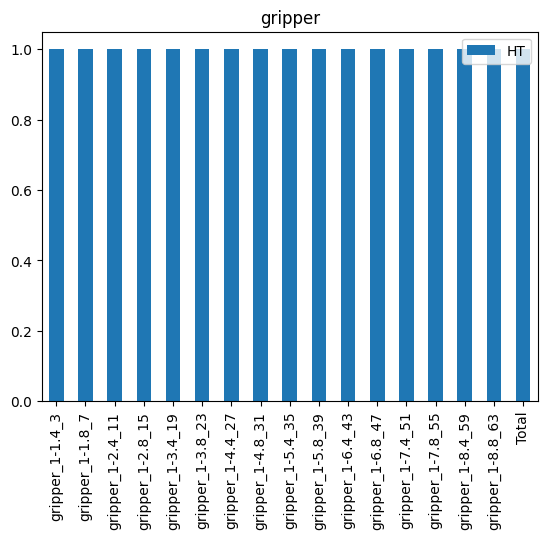

In [63]:
plot_data = pd.read_csv(os.path.join(main_dir, 'result_data_1top_size_1.csv'))
result_data_1top_gripper_1.plot.bar(y='HT', x = 'Total', title = 'size_1')

## Variation 1 - Overlap

### HT -Algorithm

In [64]:
result_HT_overlap_1 = run_HT_overlap(folder_path,files,startrow=839,overlap_p=0.10,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_overlap_2 = run_HT_overlap(folder_path,files,startrow=839,overlap_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_overlap_3 = run_HT_overlap(folder_path,files,startrow=839,overlap_p=0.50,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_overlap_4 = run_HT_overlap(folder_path,files,startrow=839,overlap_p=0.75,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_overlap_5 = run_HT_overlap(folder_path,files,startrow=839,overlap_p=0.95,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [65]:
result_overlap_HT = pd.DataFrame()
result_overlap_HT = pd.concat([result_HT_overlap_1,result_HT_overlap_2,result_HT_overlap_3,result_HT_overlap_4,result_HT_overlap_5], ignore_index=True)
result_overlap_HT['Overlap Percent'] = pd.DataFrame({'HT':['10%','20%','50%','75%','95%']})
result_overlap_HT.set_index('Overlap Percent', inplace=True)
result_overlap_HT

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Overlap Percent,,,,,,,,,,,,,,,,,,,,,
10%,"[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_2_maxVel, rob_1_maxVel, rob_2_3]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_2_maxVel, rob_1_maxVel, rob_2_3]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_2_maxVel, rob_1_maxVel, rob_2_3]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_2_maxVel, rob_1_maxVel, rob_2_3]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_2_maxVel, rob_1_maxVel, rob_2_3]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"
20%,"[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"
50%,"[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"
75%,"[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_2_maxVel, rob_1_vacuum]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"
95%,"[rob_1_maxVel, rob_2_maxVel, rob_1_

In [66]:
result_data_3top = results_top_3(result_overlap_HT,abnormal_sets)
result_data_3top.tail()


,10%,20%,50%,75%,95%
size_1-8.6_61,0.0,0.0,0.0,0.0,0.0
feeder_3-8.7_62,0.0,0.0,0.0,0.0,0.0
gripper_1-8.8_63,1.0,1.0,1.0,1.0,1.0
max_Vel_2-8.9_64,1.0,1.0,1.0,1.0,1.0
Total,0.5,0.5,0.5,0.5,0.5


In [67]:
result_data_1top = results_top_1(result_overlap_HT,abnormal_sets)
result_data_1top.tail()



,10%,20%,50%,75%,95%
size_1-8.6_61,0.0,0.0,0.0,0.0,0.0
feeder_3-8.7_62,0.0,0.0,0.0,0.0,0.0
gripper_1-8.8_63,1.0,1.0,1.0,1.0,1.0
max_Vel_2-8.9_64,1.0,1.0,1.0,1.0,1.0
Total,0.5,0.5,0.5,0.5,0.5


In [68]:

result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_1_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_1_HT.csv'))

### ED - Algorithm

In [69]:
result_ED_overlap_1 = run_ED_overlap(folder_path,files,startrow=839,overlap_p=0.10,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_ED_overlap_2 = run_ED_overlap(folder_path,files,startrow=839,overlap_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_ED_overlap_3 = run_ED_overlap(folder_path,files,startrow=839,overlap_p=0.50,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_ED_overlap_4 = run_ED_overlap(folder_path,files,startrow=839,overlap_p=0.75,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_ED_overlap_5 = run_ED_overlap(folder_path,files,startrow=839,overlap_p=0.95,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [70]:
result_overlap_ED = pd.DataFrame()
result_overlap_ED = pd.concat([result_ED_overlap_1,result_ED_overlap_2,result_ED_overlap_3,result_ED_overlap_4,result_ED_overlap_5], ignore_index=True)
result_overlap_ED['Overlap Percent'] = pd.DataFrame({'ED':['10%','20%','50%','75%','95%']})
result_overlap_ED.set_index('Overlap Percent', inplace=True)
result_overlap_ED

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Overlap Percent,,,,,,,,,,,,,,,,,,,,,
10%,"[rob_1_3, rob_1_2, rob_1_4]","[cam_2_Y, cam_3_X, EoL_1_Y]","[rob_1_3, rob_1_2, rob_1_4]","[rob_1_3, rob_1_2, rob_1_4]","[EoL_2_Y, rob_1_3, rob_1_2]","[cam_3_X, con_2, EoL_3_X]","[rob_1_3, rob_1_2, rob_1_4]","[EoL_1_X, rob_1_3, rob_1_2]","[EoL_2_Y, rob_1_3, rob_1_2]","[EoL_1_Y, EoL_1_X, cam_3_X]",...,"[rob_1_3, rob_1_2, rob_1_4]","[EoL_2_Y, rob_1_3, rob_1_2]","[EoL_2_Y, rob_1_3, rob_1_2]","[cam_3_X, con_3, EoL_3_X]","[rob_1_3, rob_1_2, rob_1_4]","[rob_1_3, rob_1_2, rob_1_4]","[EoL_1_X, EoL_2_Y, rob_1_3]","[cam_3_X, EoL_1_Y, EoL_3_X]","[rob_1_3, rob_1_2, rob_1_4]","[EoL_2_Y, rob_1_3, rob_1_2]"
20%,"[EoL_2_Y, rob_1_3, rob_1_2]","[EoL_2_X, cam_2_Y, con_1]","[EoL_1_X, rob_1_3, rob_1_2]","[EoL_1_X, EoL_2_Y, rob_1_3]","[EoL_2_Y, rob_1_3, rob_1_2]","[EoL_2_X, con_2, cam_3_X]","[rob_1_3, rob_1_2, rob_1_4]","[EoL_1_X, EoL_2_Y, rob_1_3]","[EoL_2_Y, rob_1_3, rob_1_2]","[EoL_1_X, EoL_2_X, cam_3_X]",...,"[EoL_1_X, rob_1_3, rob_1_2]","[EoL_2_Y, rob_1_3, rob_1_2]","[EoL_2_Y, rob_1_3, rob_1_2]","[EoL_2_X, cam_3_X, con_3]","[rob_1_3, rob_1_2, rob_1_4]","[EoL_2_Y, rob_1_3, rob_1_2]","[EoL_1_X, EoL_2_Y, rob_1_3]","[EoL_2_X, con_2, cam_3_X]","[rob_1_3, rob_1_2, rob_1_4]","[EoL_2_Y, rob_1_3, rob_1_2]"
50%,"[con_3, EoL_2_Y, con_1]","[cam_3_X, EoL_2_X, con_1]","[con_2, EoL_2_X, con_1]","[EoL_2_Y, con_3, rob_1_3]","[EoL_2_Y, con_2, EoL_2_X]","[cam_3_X, con_2, EoL_2_X]","[EoL_2_X, con_3, con_1]","[EoL_2_Y, con_1, con_3]","[EoL_2_Y, con_2, con_1]","[cam_3_X, EoL_2_X, con_3]",...,"[EoL_2_X, con_3, con_2]","[EoL_2_Y, con_2, con_3]","[EoL_2_Y, con_3, con_1]","[cam_3_X, EoL_2_X, con_3]","[EoL_2_X, con_3, con_1]","[EoL_4_Y, con_2, con_1]","[EoL_2_Y, con_1, con_3]","[cam_3_X, EoL_2_X, con_2]","[EoL_2_X, con_1, con_2]","[EoL_2_Y, con_2, con_1]"
75%,"[EoL_4_Y, EoL_3_Y, cam_3_Y]","[EoL_4_Y, cam_3_X, EoL_3_Y]","[EoL_4_Y, EoL_3_Y, cam_3_Y]","[EoL_6_X, cam_3_X, EoL_5_X]","[EoL_4_Y, EoL_3_Y, EoL_6_X]","[EoL_4_Y, cam_3_X, EoL_3_Y]","[EoL_4_Y, EoL_3_Y, cam_3_X]","[cam_3_Y, EoL_6_X, EoL_2_Y]","[EoL_4_Y, EoL_3_Y, cam_3_Y]","[EoL_4_Y, cam_3_X, EoL_3_Y]",...,"[EoL_4_Y, EoL_3_Y, cam_3_Y]","[cam_3_Y, EoL_5_X, EoL_6_X]","[EoL_4_Y, EoL_3_Y, cam_3_Y]","[EoL_4_Y, cam_3_X, EoL_3_Y]","[EoL_4_Y, EoL_3_Y, cam_3_Y]","[EoL_4_Y, cam_3_X, EoL_6_X]","[EoL_4_Y, EoL_3_Y, EoL_6_X]","[EoL_4_Y, cam_3_X, EoL_3_Y]","[EoL_4_Y, EoL_3_Y, cam_3_Y]","[cam_3_X, cam_3_Y, EoL_6_X]"
95%,"[cam_3_X, EoL_2_X, rob_2_vacuum]","[rob_2_vacuum, EoL_1_X, EoL_1_Y]","[cam_3_X, rob_2_vacuum, EoL_1_X]","[EoL_2_X, cam_3_X, EoL_3_X]","[EoL_2_X, cam_3_X, rob_2_vacuum]","[rob_2_vacuum, EoL_1_X, EoL_1_Y]","[cam_3_X, rob_2_vacuum, EoL_1_X]","[EoL_2_X, cam_3_X, EoL_3_X]","[cam_3_X, EoL_2_X, rob_2_vacuum]","[rob_2_vacuum, EoL_1_X, EoL_1_Y]",...,"[cam_3_X, rob_2_vacuum, EoL_1_X]","[EoL_2_X, cam_3_X, EoL_3_X]","[cam_3_X, EoL_2_X, rob_2_vacuum]","[rob_2_vacuum, EoL_1_X, EoL_1_Y]","[cam_3_X, rob_2_vacuum, EoL_1_X]","[cam_3_X, EoL_2_X, rob_2_vacuum]","[EoL_2_X, cam_3_X, rob_2_vacuum]","[rob_2_vacuum, EoL_1_X, EoL_1_Y]","[cam_3_X, rob_2_vacuum, EoL_1_X]","[cam_3_X, EoL_2_X, EoL_3_X]"


In [71]:
result_data_3top = results_top_3(result_overlap_ED,abnormal_sets)
result_data_3top.tail()

,10%,20%,50%,75%,95%
size_1-8.6_61,0.00,0.000000,0.00,0.00,0.0
feeder_3-8.7_62,1.00,1.000000,1.00,1.00,0.0
gripper_1-8.8_63,0.00,0.000000,0.00,0.00,0.0
max_Vel_2-8.9_64,0.00,0.000000,0.00,0.00,0.0
Total,0.25,0.171875,0.25,0.25,0.0


In [72]:
result_data_1top = results_top_1(result_overlap_ED,abnormal_sets)
result_data_1top.tail()

,10%,20%,50%,75%,95%
size_1-8.6_61,0.000000,0.0,0.00,0.0,0.0
feeder_3-8.7_62,1.000000,0.0,1.00,0.0,0.0
gripper_1-8.8_63,0.000000,0.0,0.00,0.0,0.0
max_Vel_2-8.9_64,0.000000,0.0,0.00,0.0,0.0
Total,0.109375,0.0,0.25,0.0,0.0


In [73]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_1_ED.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_1_ED.csv'))

### RW - Algorithm

In [74]:
result_RW_overlap_1 = run_RW_overlap(folder_path,files,startrow=839,overlap_p=0.10,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_overlap_2 = run_RW_overlap(folder_path,files,startrow=839,overlap_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_overlap_3 = run_RW_overlap(folder_path,files,startrow=839,overlap_p=0.50,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_overlap_4 = run_RW_overlap(folder_path,files,startrow=839,overlap_p=0.75,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_overlap_5 = run_RW_overlap(folder_path,files,startrow=839,overlap_p=0.95,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [75]:
result_overlap_RW = pd.DataFrame()
result_overlap_RW = pd.concat([result_RW_overlap_1,result_RW_overlap_2,result_RW_overlap_3,result_RW_overlap_4,result_RW_overlap_5], ignore_index=True)
result_overlap_RW['Overlap Percent'] = pd.DataFrame({'RW':['10%','20%','50%','75%','95%']})
result_overlap_RW.set_index('Overlap Percent', inplace=True)
result_overlap_RW

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Overlap Percent,,,,,,,,,,,,,,,,,,,,,
10%,"[rob_2_supply, cam_1_X, cam_1_Y]","[rob_2_supply, rob_1_supply, cam_3_Y]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_supply, rob_2_maxVel, rob_1_supply]","[rob_2_supply, cam_1_Y, cam_1_X]","[rob_2_supply, con_2, rob_1_supply]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_supply, cam_1_Y, cam_3_X]",...,"[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_supply, rob_2_maxVel, cam_1_X]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, con_2, rob_1_supply]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_3_X]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, cam_1_Y]"
20%,"[cam_1_Y, cam_1_X, con_2]","[rob_2_supply, cam_1_Y, rob_1_supply]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_supply, rob_2_maxVel, rob_1_supply]","[cam_1_X, cam_1_Y, rob_1_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[cam_1_Y, rob_2_supply, cam_1_X]","[rob_2_supply, rob_1_supply, cam_1_Y]",...,"[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_supply, rob_2_maxVel, cam_1_X]","[rob_2_supply, cam_1_Y, cam_1_X]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, con_2]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, rob_1_supply]"
50%,"[rob_2_supply, cam_1_Y, cam_1_X]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_supply, rob_2_maxVel, con_2]","[rob_2_supply, cam_1_Y, cam_1_X]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, cam_1_Y, cam_1_X]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_2_supply, cam_1_Y, rob_1_supply]",...,"[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_Y]","[cam_1_Y, cam_1_X, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, cam_1_Y, rob_1_supply]"
75%,"[rob_2_supply, cam_1_X, con_2]","[rob_1_supply, cam_1_Y, rob_2_maxVel]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, cam_1_Y, rob_1_supply]","[cam_1_Y, con_2, cam_1_X]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_supply, rob_2_maxVel, cam_1_X]","[rob_2_supply, cam_1_Y, con_2]","[cam_1_Y, rob_2_supply, con_2]",...,"[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, con_2]","[cam_1_Y, cam_1_X, rob_1_supply]","[rob_1_supply, cam_1_Y, cam_3_Y]","[rob_1_supply, cam_1_Y, rob_2_maxVel]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[cam_1_X, con_2, rob_1_supply]","[rob_2_supply, rob_1_supply, con_2]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, cam_1_Y]"
95%,"[rob_2_supply, rob_1_supply, con_2]","[rob_2_supply, cam_3_Y, cam_3_X]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, con_2, rob_1_supply]","[rob_2_supply, con_2, rob_1_supply]","[rob_1_supply, con_2, rob_2_supply]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[rob_2_supply, cam_1_Y, rob_1_supply]","[con_2, cam_3_Y, rob_2_supply]",...,"[rob_1_supply, con_2, rob_2_supply]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[rob_2_supply, rob_1_supply, con_2]","[rob_2_supply, con_2, rob_1_supply]","[rob_1_supply, rob_

In [76]:
result_data_3top = results_top_3(result_overlap_RW,abnormal_sets)
result_data_3top.tail()

,10%,20%,50%,75%,95%
size_1-8.6_61,1.0000,1.00,1.00,1.00,1.0000
feeder_3-8.7_62,1.0000,0.00,0.00,0.00,0.0000
gripper_1-8.8_63,1.0000,1.00,1.00,1.00,1.0000
max_Vel_2-8.9_64,1.0000,1.00,1.00,1.00,1.0000
Total,0.8125,0.75,0.75,0.75,0.6875


In [77]:
result_data_1top = results_top_1(result_overlap_RW,abnormal_sets)
result_data_1top.tail()

,10%,20%,50%,75%,95%
size_1-8.6_61,0.000000,1.000000,1.00000,1.000000,0.00000
feeder_3-8.7_62,0.000000,0.000000,0.00000,0.000000,0.00000
gripper_1-8.8_63,1.000000,1.000000,1.00000,1.000000,1.00000
max_Vel_2-8.9_64,1.000000,1.000000,1.00000,1.000000,1.00000
Total,0.484375,0.546875,0.53125,0.546875,0.46875


In [78]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_1_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_1_RW.csv'))

### RCD - Algorithm

In [79]:
result_RCD_overlap_1 = run_RCD_overlap(folder_path,files,startrow=839,overlap_p=0.10,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_overlap_2 = run_RCD_overlap(folder_path,files,startrow=839,overlap_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_overlap_3 = run_RCD_overlap(folder_path,files,startrow=839,overlap_p=0.50,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_overlap_4 = run_RCD_overlap(folder_path,files,startrow=839,overlap_p=0.75,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_overlap_5 = run_RCD_overlap(folder_path,files,startrow=839,overlap_p=0.95,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [80]:
result_overlap_RCD = pd.DataFrame()
result_overlap_RCD = pd.concat([result_RCD_overlap_1,result_RCD_overlap_2,result_RCD_overlap_3,result_RCD_overlap_4,result_RCD_overlap_5], ignore_index=True)
result_overlap_RCD['Overlap Percent'] = pd.DataFrame({'RCD':['10%','20%','50%','75%','95%']})
result_overlap_RCD.set_index('Overlap Percent', inplace=True)
result_overlap_RCD

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Overlap Percent,,,,,,,,,,,,,,,,,,,,,
10%,"[EoL_3_X, cam_2_Y, EoL_1_Y]","[EoL_2_Y, EoL_1_Y, cam_2_Y]","[EoL_2_Y, rob_1_supply, cam_2_Y]","[cam_2_Y, EoL_1_Y, EoL_2_Y]","[EoL_3_X, cam_2_Y, EoL_1_Y]","[EoL_3_X, cam_3_Y, cam_2_Y]","[rob_1_supply, cam_2_Y, cam_3_X]","[EoL_6_Y, EoL_2_X, cam_2_Y]","[EoL_3_Y, cam_2_Y, EoL_2_Y]","[EoL_2_Y, cam_2_Y, EoL_1_Y]",...,"[EoL_3_X, rob_1_supply, cam_2_Y]","[EoL_6_Y, EoL_2_X, cam_2_Y]","[EoL_3_X, cam_3_Y, EoL_1_Y]","[EoL_3_X, cam_1_Y, cam_1_X]","[EoL_3_Y, EoL_1_Y, cam_2_Y]","[EoL_6_Y, EoL_2_X, cam_2_Y]","[EoL_3_Y, cam_2_Y, EoL_1_Y]","[EoL_2_Y, cam_2_Y, EoL_1_Y]","[EoL_2_Y, cam_2_Y, EoL_1_Y]","[EoL_3_Y, EoL_2_X, cam_2_Y]"
20%,"[EoL_3_X, cam_2_Y, EoL_1_Y]","[EoL_3_X, EoL_1_Y, cam_2_Y]","[EoL_3_X, cam_2_Y, EoL_1_Y]","[cam_2_Y, EoL_1_Y, EoL_2_Y]","[EoL_3_X, EoL_1_Y, cam_3_Y]","[EoL_3_X, cam_3_Y, EoL_1_Y]","[EoL_2_Y, EoL_1_Y, cam_3_Y]","[EoL_6_Y, cam_3_Y, EoL_2_Y]","[EoL_4_Y, cam_2_Y, EoL_1_Y]","[EoL_3_X, cam_3_Y, cam_2_Y]",...,"[EoL_3_X, cam_2_Y, cam_3_Y]","[EoL_6_X, cam_2_Y, EoL_1_Y]","[EoL_4_Y, cam_2_Y, EoL_1_Y]","[cam_3_Y, EoL_3_X, EoL_1_Y]","[EoL_3_X, EoL_1_Y, cam_2_Y]","[EoL_6_X, cam_2_Y, cam_3_X]","[EoL_4_X, EoL_2_X, cam_2_Y]","[EoL_3_X, cam_3_Y, EoL_1_Y]","[EoL_3_X, cam_2_Y, EoL_1_Y]","[EoL_3_Y, cam_2_Y, EoL_1_Y]"
50%,"[cam_1_Y, EoL_2_X, cam_2_Y]","[EoL_2_Y, EoL_1_Y, cam_1_Y]","[EoL_2_Y, cam_1_Y, cam_3_X]","[EoL_6_Y, EoL_2_X, cam_1_X]","[cam_1_Y, EoL_2_X, cam_2_Y]","[EoL_2_Y, EoL_1_Y, cam_1_Y]","[EoL_2_Y, EoL_1_Y, cam_1_Y]","[rob_2_maxVel, EoL_2_X, cam_1_Y]","[cam_1_Y, EoL_2_X, EoL_3_X]","[EoL_2_Y, EoL_1_Y, cam_1_Y]",...,"[EoL_2_Y, EoL_1_Y, cam_1_X]","[EoL_6_X, EoL_2_X, cam_2_Y]","[cam_1_X, EoL_2_X, cam_2_Y]","[cam_3_X, EoL_2_Y, cam_2_Y]","[EoL_2_Y, EoL_1_Y, cam_1_X]","[EoL_6_X, EoL_2_X, cam_1_X]","[cam_1_Y, EoL_2_X, cam_2_Y]","[EoL_2_Y, EoL_1_Y, cam_1_Y]","[EoL_2_Y, cam_3_X, cam_2_Y]","[rob_2_maxVel, EoL_2_X, cam_1_Y]"
75%,"[EoL_3_X, cam_3_Y, EoL_4_X]","[EoL_2_X, cam_2_Y, EoL_2_Y]","[EoL_2_Y, cam_2_Y, EoL_1_Y]","[cam_2_Y, EoL_1_Y]","[EoL_3_X, cam_3_Y, cam_1_Y]","[EoL_2_X, cam_2_Y, EoL_2_Y]","[EoL_2_X, cam_3_Y, cam_2_Y]","[EoL_6_Y, EoL_1_Y, cam_3_Y]","[EoL_3_X, cam_2_Y, cam_3_Y]","[EoL_2_X, cam_2_Y, EoL_2_Y]",...,"[EoL_2_X, cam_2_Y, EoL_2_Y]","[rob_2_maxVel, EoL_1_Y, cam_2_Y]","[EoL_3_X, cam_3_Y, EoL_4_X]","[EoL_2_Y, EoL_1_Y, cam_2_Y]","[EoL_2_X, cam_2_Y, EoL_2_Y]","[EoL_6_Y, cam_3_Y, EoL_1_Y]","[cam_1_Y, cam_3_Y, EoL_1_Y]","[EoL_2_X, cam_2_Y, EoL_2_Y]","[EoL_2_X, EoL_2_Y, EoL_1_Y]","[rob_2_maxVel, cam_2_Y, EoL_1_Y]"
95%,"[cam_3_Y, EoL_3_Y]",[cam_3_Y],"[EoL_5_X, EoL_3_X]","[rob_2_maxVel, cam_3_X]","[EoL_5_X, cam_2_Y]","[cam_3_Y, cam_3_X]","[cam_3_Y, rob_1_supply]","[EoL_6_X, rob_2_maxVel]","[EoL_3_Y, EoL_3_X]",[EoL_2_X],...,[EoL_3_X],"[rob_2_maxVel, cam_3_X, EoL_6_X]","[EoL_5_X, cam_3_X, EoL_6_Y]","[EoL_2_X, EoL_3_X]","[rob_1_supply, EoL_3_X, cam_3_X]","[EoL_6_X, cam_3_X, EoL_6_Y]","[EoL_3_X, EoL_3_Y]",[cam_3_Y],"[EoL_3_X, cam_3_X, EoL_2_X]","[rob_2_maxVel, EoL_6_X, cam_3_X]"


In [81]:
result_data_3top = results_top_3(result_overlap_RCD,abnormal_sets)
result_data_3top.tail()

,10%,20%,50%,75%,95%
size_1-8.6_61,0.00000,0.000000,1.000000,1.000000,0.000000
feeder_3-8.7_62,0.00000,1.000000,0.000000,0.000000,1.000000
gripper_1-8.8_63,0.00000,0.000000,0.000000,0.000000,0.000000
max_Vel_2-8.9_64,0.00000,0.000000,1.000000,1.000000,1.000000
Total,0.28125,0.203125,0.390625,0.140625,0.515625


In [82]:
result_data_1top = results_top_1(result_overlap_RCD,abnormal_sets)
result_data_1top.tail()

,10%,20%,50%,75%,95%
size_1-8.6_61,0.00000,0.00000,1.000000,1.000000,0.000000
feeder_3-8.7_62,0.00000,0.00000,0.000000,0.000000,1.000000
gripper_1-8.8_63,0.00000,0.00000,0.000000,0.000000,0.000000
max_Vel_2-8.9_64,0.00000,0.00000,1.000000,1.000000,1.000000
Total,0.15625,0.09375,0.390625,0.078125,0.296875


In [83]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_1_RCD.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_1_RCD.csv'))

## Variation 2 - Normal Size

The ED-algorithm requires the same length for the normal and abnormal data set.

### HT - Algorithm

In [84]:
result_HT_normal_size_1 = run_HT_normal_size(folder_path,files,startrow=839,normal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_normal_size_2 = run_HT_normal_size(folder_path,files,startrow=839,normal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_normal_size_3 = run_HT_normal_size(folder_path,files,startrow=839,normal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_normal_size_4 = run_HT_normal_size(folder_path,files,startrow=839,normal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_normal_size_5 = run_HT_normal_size(folder_path,files,startrow=839,normal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [85]:
result_normal_size_HT = pd.DataFrame()
result_normal_size_HT = pd.concat([result_HT_normal_size_1,result_HT_normal_size_2,result_HT_normal_size_3,result_HT_normal_size_4,result_HT_normal_size_5], ignore_index=True)
result_normal_size_HT['Normal Size Percent'] = pd.DataFrame({'HT':['200%','150%','100%','50%','20%']})
result_normal_size_HT.set_index('Normal Size Percent', inplace=True)
result_normal_size_HT

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Normal Size Percent,,,,,,,,,,,,,,,,,,,,,
200%,"[rob_1_maxVel, rob_1_3, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"
150%,"[con_3, con_2, rob_1_maxVel]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, con_3]","[rob_1_maxVel, con_3, con_2]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, con_3]","[rob_1_maxVel, con_3, con_2]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, con_3]","[rob_1_maxVel, con_3, con_2]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, con_3]","[rob_1_maxVel, con_3, con_2]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, con_3]"
100%,"[rob_1_2, rob_1_1, rob_1_3]","[rob_1_maxVel, rob_1_2, rob_1_1]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[rob_1_maxVel, rob_1_1, rob_1_2]","[rob_1_maxVel, rob_1_2, rob_1_1]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[rob_1_maxVel, rob_1_1, rob_1_2]","[rob_1_maxVel, rob_1_2, rob_1_1]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[rob_1_maxVel, rob_1_2, rob_1_1]","[rob_1_maxVel, rob_1_2, rob_1_1]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[rob_1_maxVel, rob_1_2, rob_1_1]","[rob_1_maxVel, rob_1_2, rob_1_1]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]"
50%,"[rob_1_3, rob_1_1, rob_1_2]","[cam_3_X, rob_1_maxVel, EoL_2_X]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_2_1]","[rob_1_maxVel, rob_1_3, rob_1_2]","[cam_3_X, rob_1_maxVel, EoL_2_X]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_2_1]","[rob_1_maxVel, rob_1_3, rob_1_2]","[cam_3_X, rob_1_maxVel, EoL_2_X]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_2_1]","[rob_1_maxVel, rob_1_3, rob_1_2]","[cam_3_X, rob_1_maxVel, EoL_2_X]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, rob_2_1]","[rob_1_maxVel, rob_1_3, rob_1_1]","[cam_3_X, rob_1_maxVel, EoL_2_X]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_2_1]"
20%,"[cam_1_X, cam_1_Y, rob_1_maxVel]","[rob_2_maxVel, score, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_3]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[cam_1_X, cam_1_Y, rob_1_maxVel]","[rob_2_maxVel, cam_1_X, score]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[cam_1_X, cam_1_Y, rob_1_3]","[rob_2_maxVel, score, rob_1_maxVel]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[cam_1_X, 

In [86]:
result_data_3top = results_top_3(result_normal_size_HT,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.0000,0.00,0.0,0.00,1.00
feeder_3-8.7_62,0.0000,1.00,0.0,1.00,0.00
gripper_1-8.8_63,1.0000,1.00,1.0,1.00,1.00
max_Vel_2-8.9_64,1.0000,1.00,1.0,1.00,1.00
Total,0.5625,0.75,0.5,0.75,0.75


In [87]:
result_data_1top = results_top_1(result_normal_size_HT,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.0,0.00,0.0,0.00,1.00
feeder_3-8.7_62,0.0,1.00,0.0,1.00,0.00
gripper_1-8.8_63,1.0,1.00,1.0,1.00,1.00
max_Vel_2-8.9_64,1.0,1.00,1.0,1.00,1.00
Total,0.5,0.75,0.5,0.75,0.75


In [88]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_2_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_2_HT.csv'))

### RW - Algorithm

In [89]:
result_RW_normal_size_1 = run_RW_normal_size(folder_path,files,startrow=839,normal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_normal_size_2 = run_RW_normal_size(folder_path,files,startrow=839,normal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_normal_size_3 = run_RW_normal_size(folder_path,files,startrow=839,normal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_normal_size_4 = run_RW_normal_size(folder_path,files,startrow=839,normal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_normal_size_5 = run_RW_normal_size(folder_path,files,startrow=839,normal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [90]:
result_normal_size_RW = pd.DataFrame()
result_normal_size_RW = pd.concat([result_RW_normal_size_1,result_RW_normal_size_2,result_RW_normal_size_3,result_RW_normal_size_4,result_RW_normal_size_5], ignore_index=True)
result_normal_size_RW['Normal Size Percent'] = pd.DataFrame({'RW':['200%','150%','100%','50%','20%']})
result_normal_size_RW.set_index('Normal Size Percent', inplace=True)
result_normal_size_RW

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Normal Size Percent,,,,,,,,,,,,,,,,,,,,,
200%,"[cam_1_X, rob_2_supply, rob_1_supply]","[rob_2_supply, rob_1_supply, rob_2_maxVel]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[cam_1_Y, cam_1_X, rob_2_supply]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[cam_1_Y, cam_1_X, rob_2_supply]","[rob_1_supply, rob_2_supply, cam_1_Y]",...,"[rob_1_supply, rob_2_supply, cam_1_X]","[rob_1_supply, rob_2_maxVel, rob_2_supply]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_supply, rob_2_maxVel, rob_1_supply]","[cam_1_X, cam_1_Y, rob_1_supply]","[rob_2_supply, rob_1_supply, cam_1_X]","[rob_1_supply, con_2, rob_2_supply]","[rob_2_maxVel, rob_1_supply, cam_1_X]"
150%,"[cam_1_X, cam_1_Y, rob_1_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[cam_1_Y, cam_1_X, rob_2_supply]","[rob_2_supply, cam_1_X, rob_1_supply]","[rob_1_supply, cam_1_X, rob_2_maxVel]","[rob_2_maxVel, rob_2_supply, cam_1_Y]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_1_supply, rob_2_supply, cam_1_Y]",...,"[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_1_supply, cam_1_Y, rob_2_maxVel]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_Y]","[cam_1_Y, cam_1_X, rob_2_maxVel]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_maxVel, cam_1_X]","[rob_2_maxVel, cam_1_Y, cam_1_X]"
100%,"[cam_1_Y, cam_1_X, rob_2_supply]","[rob_2_supply, cam_3_X, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, cam_2_Y, cam_3_X]","[cam_1_Y, cam_1_X, cam_3_X]","[cam_3_X, cam_3_Y, cam_1_X]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, cam_3_X, rob_2_supply]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_2_supply, cam_3_X, cam_3_Y]",...,"[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, cam_3_X, cam_2_Y]","[cam_1_Y, cam_1_X, rob_2_supply]","[cam_3_X, cam_3_Y, rob_1_supply]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_supply, rob_2_maxVel, cam_3_X]","[cam_1_Y, cam_1_X, cam_3_X]","[rob_2_supply, rob_1_supply, cam_3_Y]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, cam_3_X, rob_2_supply]"
50%,"[cam_1_Y, cam_1_X, rob_2_supply]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_1_supply, cam_1_X]","[cam_1_X, cam_1_Y, rob_2_supply]","[cam_1_X, rob_2_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[cam_1_Y, cam_1_X, rob_2_supply]","[cam_1_Y, rob_2_supply, cam_1_X]",...,"[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_1_supply, cam_1_X]","[cam_1_Y, cam_1_X, rob_2_supply]","[rob_1_supply, cam_1_Y, rob_2_supply]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, cam_1_X, rob_2_supply]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_1_X]","[rob_1_supply, cam_1_X, cam_1_Y]","[rob_2_maxVel, cam_1_X, rob_1_supply]"
20%,"[cam_1_X, cam_1_Y, rob_1_supply]","[cam_1_X, rob_1_supply, rob_2_supply]","[rob_1_supply, cam_1_X, cam_1_Y]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[cam_1_X, cam_1_Y, rob_1_supply]","[cam_1_X, cam_1_Y, con_2]","[rob_1_supply, cam_1_X, cam_1_Y]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[cam_1_X, cam_1_Y, con_2]","[cam_1_X, rob_1_supply, con_2]",...,"[rob_1_supply, cam_1_X, cam_1_Y]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[cam_1_Y, cam_1_X, con_2]","[cam_1_X, rob_1_supply, cam_1_Y]","[rob_1_supply, cam_1_X, cam_1_Y]","[rob_2_maxVel, cam_1_X, ca

In [91]:
result_data_3top = results_top_3(result_normal_size_RW,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,1.00000,1.00,1.0,1.00,1.00
feeder_3-8.7_62,0.00000,0.00,1.0,0.00,0.00
gripper_1-8.8_63,1.00000,1.00,1.0,1.00,1.00
max_Vel_2-8.9_64,1.00000,1.00,1.0,1.00,1.00
Total,0.78125,0.75,1.0,0.75,0.75


In [92]:
result_data_1top = results_top_1(result_normal_size_RW,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,1.000000,1.00000,1.000,1.00,1.00
feeder_3-8.7_62,0.000000,0.00000,0.000,0.00,0.00
gripper_1-8.8_63,1.000000,1.00000,1.000,1.00,1.00
max_Vel_2-8.9_64,1.000000,1.00000,1.000,1.00,1.00
Total,0.484375,0.71875,0.625,0.75,0.75


In [93]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_2_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_2_RW.csv'))

### RCD - Algorithm

In [94]:
result_RCD_normal_size_1 = run_RCD_normal_size(folder_path,files,startrow=839,normal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_normal_size_2 = run_RCD_normal_size(folder_path,files,startrow=839,normal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_normal_size_3 = run_RCD_normal_size(folder_path,files,startrow=839,normal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_normal_size_4 = run_RCD_normal_size(folder_path,files,startrow=839,normal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_normal_size_5 = run_RCD_normal_size(folder_path,files,startrow=839,normal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)


In [95]:
result_normal_size_RCD = pd.DataFrame()
result_normal_size_RCD = pd.concat([result_RCD_normal_size_1,result_RCD_normal_size_2,result_RCD_normal_size_3,result_RCD_normal_size_4,result_RCD_normal_size_5], ignore_index=True)
result_normal_size_RCD['Normal Size Percent'] = pd.DataFrame({'RCD':['200%','150%','100%','50%','20%']})
result_normal_size_RCD.set_index('Normal Size Percent', inplace=True)
result_normal_size_RCD

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Normal Size Percent,,,,,,,,,,,,,,,,,,,,,
200%,"[EoL_4_X, cam_1_X]","[EoL_6_Y, EoL_2_X]","[EoL_3_Y, EoL_6_Y]",[EoL_6_X],"[EoL_4_X, EoL_6_X, EoL_6_Y]","[EoL_4_X, EoL_3_X, cam_3_Y]","[EoL_2_Y, EoL_4_Y, EoL_5_Y]",[EoL_6_Y],"[EoL_3_Y, EoL_6_Y, EoL_3_X]","[EoL_5_Y, EoL_6_Y]",...,"[EoL_2_Y, EoL_5_X, EoL_2_X]","[EoL_6_X, EoL_6_Y]","[EoL_4_X, EoL_6_X]","[EoL_3_X, EoL_5_Y, EoL_4_Y]","[rob_1_supply, EoL_4_Y, EoL_2_Y]",[EoL_6_X],"[cam_1_X, EoL_6_X, EoL_3_X]","[EoL_5_X, cam_3_Y]","[EoL_5_X, EoL_4_Y, EoL_2_X]",[rob_2_maxVel]
150%,"[EoL_5_X, EoL_6_Y, EoL_6_X]","[EoL_6_X, EoL_6_Y]","[EoL_4_X, EoL_2_Y, rob_1_supply]",[rob_2_maxVel],"[EoL_5_X, cam_1_Y]","[EoL_6_X, EoL_4_X, cam_3_X]","[EoL_4_Y, EoL_4_X, EoL_5_Y]",[EoL_6_Y],"[EoL_6_X, EoL_6_Y]","[cam_3_X, EoL_6_Y]",...,"[EoL_4_X, EoL_2_Y]","[EoL_6_X, EoL_6_Y]","[cam_1_Y, EoL_4_X, EoL_5_X]","[EoL_6_Y, EoL_5_X, EoL_4_X]","[EoL_3_X, EoL_5_Y]",[EoL_6_Y],"[EoL_6_Y, cam_1_Y]","[EoL_5_Y, EoL_2_X]","[EoL_2_X, rob_1_supply]","[EoL_6_X, rob_2_maxVel, EoL_6_Y]"
100%,"[EoL_6_Y, cam_1_Y]","[EoL_4_X, EoL_6_Y, EoL_2_Y]","[EoL_6_Y, EoL_3_X, EoL_4_Y]",[rob_2_maxVel],"[EoL_4_X, EoL_4_Y]","[EoL_4_X, EoL_3_Y]","[EoL_2_Y, EoL_5_Y]","[EoL_6_X, rob_2_maxVel]","[EoL_6_Y, EoL_6_X, EoL_4_Y]","[EoL_3_Y, EoL_6_X]",...,"[rob_1_supply, EoL_2_Y, EoL_6_X]","[EoL_6_Y, rob_2_maxVel]","[EoL_5_Y, EoL_6_Y, EoL_3_X]","[EoL_3_X, EoL_2_Y, EoL_2_X]","[EoL_5_Y, EoL_4_Y, EoL_3_X]","[rob_2_maxVel, EoL_6_Y]","[EoL_5_Y, EoL_6_Y]","[EoL_2_Y, EoL_3_X, cam_3_Y]","[EoL_3_Y, EoL_4_X]","[EoL_6_X, EoL_2_X]"
50%,"[cam_1_Y, EoL_5_Y, EoL_6_Y]","[EoL_5_X, EoL_2_Y]","[EoL_4_Y, EoL_2_Y]",[EoL_6_Y],"[cam_1_Y, EoL_5_X]","[EoL_4_X, EoL_2_Y]","[EoL_2_Y, EoL_5_Y]",[EoL_6_Y],"[cam_1_Y, EoL_4_X]","[EoL_6_Y, EoL_3_X, EoL_3_Y]",...,"[EoL_5_Y, EoL_5_X]",[EoL_6_Y],"[EoL_5_Y, EoL_5_X]","[EoL_2_Y, EoL_3_X]","[EoL_3_X, EoL_6_Y]",[EoL_6_Y],"[EoL_4_Y, cam_1_Y, EoL_3_Y]","[cam_3_X, EoL_6_Y, EoL_5_Y]","[rob_1_supply, EoL_4_X, EoL_3_Y]","[EoL_2_X, rob_2_maxVel]"
20%,"[EoL_4_X, EoL_5_Y, EoL_3_X]","[EoL_5_X, EoL_2_X, EoL_2_Y]","[EoL_6_Y, cam_3_X]","[EoL_6_X, rob_2_maxVel]","[EoL_3_X, EoL_5_Y]","[EoL_5_Y, EoL_4_X, EoL_3_Y]","[EoL_3_X, cam_3_X]","[EoL_6_Y, cam_3_X]","[cam_1_X, EoL_6_X, EoL_2_X]","[cam_3_X, cam_3_Y, EoL_3_X]",...,"[EoL_1_Y, EoL_2_Y]","[EoL_2_X, cam_3_X, rob_2_maxVel]","[EoL_5_X, cam_1_X]","[EoL_2_Y, EoL_5_X, EoL_2_X]","[EoL_4_Y, EoL_2_X]","[rob_2_maxVel, EoL_6_X]","[cam_1_Y, EoL_3_X]","[EoL_2_X, EoL_5_X]","[EoL_5_X, EoL_6_Y, EoL_3_Y]","[EoL_5_X, cam_2_Y]"


In [96]:
result_data_3top = results_top_3(result_normal_size_RCD,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,1.000000,1.0,0.000000,1.000000,1.000000
feeder_3-8.7_62,1.000000,0.0,1.000000,1.000000,0.000000
gripper_1-8.8_63,0.000000,1.0,0.000000,1.000000,0.000000
max_Vel_2-8.9_64,1.000000,1.0,0.000000,1.000000,0.000000
Total,0.359375,0.5,0.421875,0.296875,0.328125


In [97]:
result_data_1top = results_top_1(result_normal_size_RCD,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,1.000000,0.000000,0.000000,0.00000,1.000000
feeder_3-8.7_62,0.000000,0.000000,0.000000,1.00000,0.000000
gripper_1-8.8_63,0.000000,0.000000,0.000000,1.00000,0.000000
max_Vel_2-8.9_64,1.000000,0.000000,0.000000,0.00000,0.000000
Total,0.171875,0.296875,0.171875,0.21875,0.171875


In [98]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_2_RCD.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_2_RCD.csv'))

## Variation 3 - Abnormal Size

The ED-algorithm requires the same length for the normal and abnormal data set.

### HT - Algorithm

In [99]:
result_HT_abnormal_size_1 = run_HT_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_abnormal_size_2 = run_HT_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_abnormal_size_3 = run_HT_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_abnormal_size_4 = run_HT_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_abnormal_size_5 = run_HT_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [100]:
result_abnormal_size_HT = pd.DataFrame()
result_abnormal_size_HT = pd.concat([result_HT_abnormal_size_1,result_HT_abnormal_size_2,result_HT_abnormal_size_3,result_HT_abnormal_size_4,result_HT_abnormal_size_5], ignore_index=True)
result_abnormal_size_HT['abnormal Size Percent'] = pd.DataFrame({'HT':['200%','150%','100%','50%','20%']})
result_abnormal_size_HT.set_index('abnormal Size Percent', inplace=True)
result_abnormal_size_HT

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
abnormal Size Percent,,,,,,,,,,,,,,,,,,,,,
200%,"[rob_1_maxVel, rob_1_3, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"
150%,"[rob_1_maxVel, rob_1_3, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"
100%,"[rob_1_1, rob_1_3, rob_1_2]","[rob_2_maxVel, EoL_4_Y, cam_3_X]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]","[rob_1_1, rob_1_3, rob_1_2]","[rob_2_maxVel, EoL_4_Y, cam_3_X]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, EoL_4_Y, cam_3_X]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_1, rob_1_3, rob_1_2]","[rob_2_maxVel, EoL_4_Y, cam_3_X]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, EoL_4_Y, cam_3_X]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]"
50%,"[rob_1_1, rob_1_3, rob_1_2]","[EoL_4_Y, cam_3_X, EoL_5_Y]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]","[rob_1_1, rob_1_3, rob_1_2]","[rob_2_maxVel, EoL_4_Y, cam_3_X]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]","[rob_1_1, rob_1_3, rob_1_2]","[EoL_4_Y, cam_3_X, EoL_5_Y]",...,"[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]","[rob_1_1, rob_1_3, rob_1_2]","[EoL_4_Y, cam_3_X, EoL_5_Y]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]","[rob_1_1, rob_1_3, rob_1_2]","[EoL_4_Y, cam_3_X, EoL_5_Y]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]"
20%,"[rob_1_1, rob_1_3, rob_1_2]","[EoL_4_Y, cam_3_X, EoL_5_Y]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]","[rob_1_1, rob_1_3, rob_1_2]","[EoL_4_Y, cam_3_X, EoL_5_Y]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]","[rob_1_1, rob_1_3, rob_1_2]","[EoL_4_Y, cam_3_X, EoL_5_Y]",...,"[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_1_1]","[rob_1_1, rob_1_3, rob_1_2]","[EoL_4_Y, cam_3_X, EoL_5_Y]","[rob_1_suppl

In [101]:
result_data_3top = results_top_3(result_abnormal_size_HT,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.000000,0.000000,0.00,0.00,0.00
feeder_3-8.7_62,0.000000,0.000000,1.00,1.00,1.00
gripper_1-8.8_63,1.000000,1.000000,1.00,1.00,1.00
max_Vel_2-8.9_64,1.000000,1.000000,1.00,1.00,1.00
Total,0.578125,0.578125,0.75,0.75,0.75


In [102]:
result_data_1top = results_top_1(result_abnormal_size_HT,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.0,0.0,0.0,0.0,0.0
feeder_3-8.7_62,0.0,0.0,0.0,0.0,0.0
gripper_1-8.8_63,1.0,1.0,1.0,1.0,1.0
max_Vel_2-8.9_64,1.0,1.0,1.0,1.0,1.0
Total,0.5,0.5,0.5,0.5,0.5


In [103]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_3_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_3_HT.csv'))

### RW - Algorithm

In [104]:
result_RW_abnormal_size_1 = run_RW_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_abnormal_size_2 = run_RW_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_abnormal_size_3 = run_RW_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_abnormal_size_4 = run_RW_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_abnormal_size_5 = run_RW_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [105]:
result_abnormal_size_RW = pd.DataFrame()
result_abnormal_size_RW = pd.concat([result_RW_abnormal_size_1,result_RW_abnormal_size_2,result_RW_abnormal_size_3,result_RW_abnormal_size_4,result_RW_abnormal_size_5], ignore_index=True)
result_abnormal_size_RW['abnormal Size Percent'] = pd.DataFrame({'RW':['200%','150%','100%','50%','20%']})
result_abnormal_size_RW.set_index('abnormal Size Percent', inplace=True)
result_abnormal_size_RW

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
abnormal Size Percent,,,,,,,,,,,,,,,,,,,,,
200%,"[rob_2_supply, rob_1_supply, con_2]","[rob_2_supply, rob_1_supply, cam_3_X]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[rob_2_supply, rob_1_supply, con_2]","[rob_2_supply, rob_1_supply, con_2]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[rob_2_supply, con_2, cam_1_X]","[rob_1_supply, rob_2_supply, con_2]",...,"[rob_1_supply, rob_2_supply, con_2]","[rob_2_supply, rob_2_maxVel, rob_1_supply]","[rob_2_supply, rob_1_supply, cam_1_X]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_1_supply, rob_2_supply, cam_2_X]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[rob_2_supply, rob_1_supply, cam_1_X]","[rob_1_supply, rob_2_supply, cam_3_Y]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, rob_1_supply]"
150%,"[rob_2_supply, rob_1_supply, con_2]","[rob_2_supply, rob_1_supply, cam_3_X]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_supply, rob_2_maxVel, cam_1_X]","[rob_2_supply, rob_1_supply, cam_1_X]","[rob_2_supply, rob_1_supply, cam_1_X]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, cam_1_Y]","[rob_2_supply, cam_1_Y, con_2]","[rob_1_supply, rob_2_supply, con_2]",...,"[rob_1_supply, rob_2_supply, cam_3_X]","[rob_2_supply, rob_2_maxVel, rob_1_supply]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_3_X]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, cam_1_Y, rob_1_supply]","[rob_2_supply, rob_1_supply, con_2]","[rob_2_supply, rob_1_supply, con_2]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, cam_1_Y]"
100%,"[rob_1_supply, cam_2_Y, rob_2_supply]","[rob_2_supply, rob_1_supply, con_2]","[rob_1_supply, rob_2_supply, cam_2_X]","[rob_2_supply, rob_2_maxVel, cam_2_Y]","[cam_3_X, cam_2_Y, con_2]","[rob_1_supply, rob_2_supply, con_2]","[rob_1_supply, rob_2_supply, cam_2_Y]","[rob_2_maxVel, rob_2_supply, cam_2_Y]","[rob_2_supply, cam_2_X, cam_1_X]","[rob_1_supply, rob_2_supply, cam_3_X]",...,"[rob_1_supply, cam_2_Y, rob_2_supply]","[rob_2_maxVel, rob_2_supply, cam_2_Y]","[rob_2_supply, cam_2_X, rob_1_supply]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_1_supply, rob_2_supply, cam_2_X]","[rob_2_maxVel, cam_1_Y, cam_2_X]","[rob_2_supply, cam_2_Y, rob_1_supply]","[rob_1_supply, rob_2_supply, cam_3_X]","[rob_1_supply, rob_2_supply, cam_2_X]","[rob_2_maxVel, rob_2_supply, cam_2_X]"
50%,"[rob_1_supply, rob_2_supply, con_2]","[rob_2_supply, rob_1_supply, con_2]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_1_supply, rob_2_supply]","[rob_2_supply, rob_1_supply, con_2]","[rob_1_supply, rob_2_supply, con_2]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, rob_1_supply]","[rob_2_supply, rob_1_supply, cam_2_X]","[rob_2_supply, rob_1_supply, con_2]",...,"[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_1_supply, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, con_2]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_supply, rob_2_maxVel, rob_1_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, rob_1_supply]"
20%,"[rob_2_supply, con_2, rob_1_supply]","[rob_2_supply, rob_1_supply, con_2]","[rob_2_supply, rob_1_supply, con_2]","[rob_2_maxVel, con_2, rob_1_supply]","[rob_2_supply, con_2, rob_1_supply]","[rob_1_supply, rob_2_supply, con_2]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_1_supply, con_1]","[rob_2_supply, rob_1_supply, con_2]","[rob_1_supply, rob_2_supply, con_2]",...,"[rob_1_supply, rob_2_supply, con_2]","[rob_2_max

In [106]:
result_data_3top = results_top_3(result_abnormal_size_RW,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,1.000000,0.000000,0.00000,1.0000,0.00000
feeder_3-8.7_62,1.000000,0.000000,1.00000,0.0000,0.00000
gripper_1-8.8_63,1.000000,1.000000,1.00000,1.0000,1.00000
max_Vel_2-8.9_64,1.000000,1.000000,1.00000,1.0000,1.00000
Total,0.765625,0.703125,0.59375,0.5625,0.53125


In [107]:
result_data_1top = results_top_1(result_abnormal_size_RW,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.0,0.000000,0.000000,0.000000,0.000
feeder_3-8.7_62,0.0,0.000000,0.000000,0.000000,0.000
gripper_1-8.8_63,1.0,1.000000,1.000000,1.000000,1.000
max_Vel_2-8.9_64,1.0,1.000000,1.000000,1.000000,1.000
Total,0.5,0.453125,0.484375,0.484375,0.375


In [108]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_3_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_3_RW.csv'))

### RCD - Algorithm

In [109]:
result_RCD_abnormal_size_1 = run_RCD_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_abnormal_size_2 = run_RCD_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_abnormal_size_3 = run_RCD_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_abnormal_size_4 = run_RCD_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_abnormal_size_5 = run_RCD_abnormal_size(folder_path,files,startrow=839,abnormal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)


In [110]:
result_abnormal_size_RCD = pd.DataFrame()
result_abnormal_size_RCD = pd.concat([result_RCD_abnormal_size_1,result_RCD_abnormal_size_2,result_RCD_abnormal_size_3,result_RCD_abnormal_size_4,result_RCD_abnormal_size_5], ignore_index=True)
result_abnormal_size_RCD['abnormal Size Percent'] = pd.DataFrame({'RCD':['200%','150%','100%','50%','20%']})
result_abnormal_size_RCD.set_index('abnormal Size Percent', inplace=True)
result_abnormal_size_RCD

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
abnormal Size Percent,,,,,,,,,,,,,,,,,,,,,
200%,"[EoL_6_X, EoL_3_X, EoL_6_Y]","[EoL_3_X, EoL_4_Y]","[EoL_6_Y, EoL_4_X]","[rob_2_maxVel, EoL_6_Y]",[EoL_3_X],"[cam_3_X, EoL_5_X]","[EoL_6_X, EoL_3_Y]","[EoL_6_Y, rob_2_maxVel]","[cam_1_X, EoL_5_Y, EoL_6_X]","[EoL_6_Y, EoL_2_X, EoL_6_X]",...,"[EoL_5_X, EoL_2_X, EoL_4_Y]",[rob_2_maxVel],"[EoL_3_X, EoL_4_X, cam_1_X]",[EoL_6_X],"[EoL_3_X, EoL_5_Y, EoL_6_Y]",[EoL_6_X],"[EoL_5_X, EoL_4_X]","[EoL_4_X, EoL_5_Y]","[EoL_3_Y, EoL_3_X]","[EoL_6_Y, rob_2_maxVel]"
150%,"[EoL_5_Y, cam_1_X]","[EoL_3_X, EoL_6_Y, cam_3_Y]","[EoL_3_X, EoL_3_Y]",[EoL_6_Y],"[EoL_6_Y, EoL_4_X, cam_1_Y]","[EoL_2_X, EoL_3_Y, EoL_3_X]","[EoL_5_Y, EoL_3_Y, EoL_4_Y]",[EoL_6_X],"[EoL_4_Y, EoL_3_Y]","[EoL_5_Y, cam_3_X]",...,"[EoL_3_Y, EoL_5_Y]","[EoL_6_Y, rob_2_maxVel]","[EoL_3_Y, EoL_6_Y]","[EoL_5_X, cam_3_X]","[EoL_4_X, EoL_2_Y, EoL_6_X]","[rob_2_maxVel, EoL_6_X]","[cam_1_Y, EoL_6_Y, EoL_5_X]","[cam_3_X, EoL_4_Y, EoL_2_X]","[EoL_4_X, EoL_3_X]","[EoL_6_Y, EoL_6_X]"
100%,"[EoL_4_X, EoL_4_Y]","[EoL_2_Y, EoL_4_X, EoL_6_Y]","[EoL_3_X, EoL_5_X, EoL_5_Y]","[EoL_6_X, rob_2_maxVel]","[EoL_6_X, EoL_5_X]","[EoL_5_X, EoL_5_Y]","[EoL_3_Y, EoL_4_X]",[EoL_6_X],"[EoL_3_Y, cam_1_Y, cam_1_X]","[cam_3_X, EoL_4_Y]",...,"[EoL_2_X, EoL_6_X, EoL_5_X]","[EoL_6_Y, EoL_6_X]","[EoL_5_Y, cam_1_Y]","[EoL_6_X, cam_3_Y]","[EoL_4_X, EoL_4_Y]",[rob_2_maxVel],"[EoL_3_Y, cam_1_Y]","[EoL_6_Y, EoL_3_X, EoL_5_X]","[EoL_4_X, EoL_6_X]",[rob_2_maxVel]
50%,"[cam_1_Y, EoL_3_X, cam_1_X]","[EoL_3_X, EoL_5_Y, EoL_3_Y]","[EoL_3_X, EoL_5_Y]",[EoL_6_X],"[EoL_4_Y, EoL_3_Y, EoL_4_X]","[EoL_6_X, EoL_6_Y]","[EoL_2_X, EoL_6_Y]","[EoL_6_Y, rob_2_maxVel]","[EoL_5_Y, EoL_3_Y]","[EoL_6_Y, EoL_3_X, EoL_2_Y]",...,[EoL_5_X],"[rob_2_maxVel, EoL_6_Y]","[EoL_3_X, EoL_4_X, EoL_3_Y]","[EoL_5_Y, EoL_6_Y, EoL_2_X]","[EoL_6_X, EoL_5_X, EoL_3_Y]","[cam_2_X, EoL_6_Y]","[EoL_3_Y, EoL_6_Y]","[EoL_5_Y, cam_3_Y, EoL_2_X]","[EoL_3_X, EoL_2_X, rob_1_supply]","[EoL_6_Y, EoL_6_X]"
20%,"[EoL_5_X, cam_1_Y]","[EoL_3_Y, EoL_4_X]","[cam_3_Y, EoL_5_Y]","[EoL_6_Y, EoL_6_X, EoL_5_Y]","[EoL_6_X, EoL_3_Y]","[EoL_6_X, EoL_2_X]","[EoL_4_X, EoL_3_X, EoL_4_Y]","[EoL_3_Y, EoL_6_Y]","[EoL_2_Y, EoL_4_X]","[EoL_3_X, EoL_3_Y]",...,"[EoL_5_Y, EoL_2_Y]","[EoL_4_Y, EoL_6_X, EoL_6_Y]","[cam_1_Y, EoL_4_Y]","[EoL_4_Y, EoL_5_Y, EoL_2_X]","[EoL_2_Y, EoL_4_Y]","[rob_2_maxVel, EoL_6_X]","[cam_1_X, EoL_3_X]","[EoL_5_Y, EoL_2_Y]","[EoL_3_X, EoL_6_Y]","[EoL_6_Y, EoL_6_X, cam_2_X]"


In [111]:
result_data_3top = results_top_3(result_abnormal_size_RCD,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.000000,1.000000,1.000000,0.000,1.00000
feeder_3-8.7_62,0.000000,1.000000,0.000000,1.000,0.00000
gripper_1-8.8_63,0.000000,0.000000,0.000000,1.000,0.00000
max_Vel_2-8.9_64,1.000000,0.000000,1.000000,0.000,0.00000
Total,0.453125,0.453125,0.453125,0.375,0.28125


In [112]:
result_data_1top = results_top_1(result_abnormal_size_RCD,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.000000,1.000000,0.00000,0.000000,1.0000
feeder_3-8.7_62,0.000000,1.000000,0.00000,0.000000,0.0000
gripper_1-8.8_63,0.000000,0.000000,0.00000,0.000000,0.0000
max_Vel_2-8.9_64,0.000000,0.000000,1.00000,0.000000,0.0000
Total,0.265625,0.171875,0.15625,0.203125,0.1875


In [113]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_3_RCD.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_3_RCD.csv'))

## Variation 4 - Causal Graph, adjacency matrix

Only the HT- and RW-Algorithm use an adjacency matrix for training of each model.

### HT - Algorithm

In [114]:
result_HT_edges_1 = run_HT_edges_delete(folder_path,files,startrow=839,edges_delete_n=20,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_edges_2 = run_HT_edges_delete(folder_path,files,startrow=839,edges_delete_n=40,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_edges_3 = run_HT_edges_delete(folder_path,files,startrow=839,edges_delete_n=60,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_edges_4 = run_HT_edges_delete(folder_path,files,startrow=839,edges_delete_n=80,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_edges_5 = run_HT_edges_delete(folder_path,files,startrow=839,edges_delete_n=100,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [115]:
result_edges_HT = pd.DataFrame()
result_edges_HT = pd.concat([result_HT_edges_1,result_HT_edges_2,result_HT_edges_3,result_HT_edges_4,result_HT_edges_5], ignore_index=True)
result_edges_HT['Edges Missing'] = pd.DataFrame({'HT':['20','40','60','80','100']})
result_edges_HT.set_index('Edges Missing', inplace=True)
result_edges_HT

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Edges Missing,,,,,,,,,,,,,,,,,,,,,
20,"[rob_1_maxVel, rob_1_3, rob_1_1]","[rob_2_maxVel, cam_3_X, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, cam_3_X, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_3]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, cam_3_X, rob_1_maxVel]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_1]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, cam_3_X, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, cam_3_X, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_3]"
40,"[rob_1_maxVel, rob_1_3, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_1]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_3]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_1]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_3]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_3]"
60,"[rob_1_maxVel, rob_1_3, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"
80,"[EoL_4_Y, rob_1_maxVel, rob_1_1]","[EoL_4_Y, rob_1_maxVel, EoL_5_X]","[rob_1_supply, EoL_4_Y, rob_1_maxVel]","[rob_2_maxVel, rob_1_1, EoL_6_X]","[EoL_4_Y, rob_1_maxVel, rob_1_1]","[EoL_4_Y, rob_1_maxVel, EoL_5_X]","[rob_1_supply, EoL_4_Y, rob_1_maxVel]","[rob_2_maxVel, rob_1_1, EoL_6_X]","[EoL_4_Y, rob_1_maxVel, rob_1_1]","[EoL_4_Y, rob_1_maxVel, EoL_5_X]",...,"[rob_1_supply, EoL_4_Y, rob_1_maxVel]","[rob_2_maxVel, rob_1_1, EoL_6_X]","[EoL_4_Y, rob_1_maxVel, rob_1_1]","[EoL_4_Y, rob_1_maxVel, EoL_5_X]","[rob_1_supply, EoL_4_Y, rob_1_maxVel]","[rob_2_maxVel, rob_1_1, EoL_6_X]","[EoL_4_Y, rob_1_maxVel, rob_1_1]","[EoL_4_Y, rob_1_maxVel, EoL_5_X]","[rob_1_supply, EoL_4_Y, rob_1_maxVel]","[rob_2_maxVel, rob_1_1, EoL_6_X]"
100,"[rob_1_1, EoL_4_Y, rob_1_4]","[EoL_2_Y, cam_3_Y, score]","[rob_1_supply, rob_1_1, rob_1_4]","[rob_2_maxVel, rob_1_1, EoL_6_X]","[rob_1_1, EoL_4_Y, rob_1_4]","[EoL_2_Y, cam_3_Y, score]","[rob_1_supply, rob_1_1, rob_1_4]","[rob_2_maxVel, rob_1_1, EoL_6_X]","[rob_1_1, EoL_4_Y, rob_1_4]","[EoL_2_Y, cam_3_Y, score]",...,"[rob_1_supply, rob_1_1, rob_1_4]","[rob_2_maxVel, rob_1_1, EoL_6_X]","[rob_1_1, EoL_4_Y, rob_1_4]","[EoL_2_Y, cam_3_Y, score]","[rob_1_sup

In [116]:
result_data_3top = results_top_3(result_edges_HT,abnormal_sets)
result_data_3top.tail()

,20,40,60,80,100
size_1-8.6_61,0.00,0.0000,0.0,0.0,0.000000
feeder_3-8.7_62,1.00,0.0000,0.0,0.0,1.000000
gripper_1-8.8_63,1.00,1.0000,1.0,1.0,1.000000
max_Vel_2-8.9_64,1.00,1.0000,1.0,1.0,1.000000
Total,0.75,0.5625,0.5,0.5,0.734375


In [117]:
result_data_1top = results_top_1(result_edges_HT,abnormal_sets)
result_data_1top.tail()

,20,40,60,80,100
size_1-8.6_61,0.00000,0.0,0.0,0.0,0.000000
feeder_3-8.7_62,0.00000,0.0,0.0,0.0,0.000000
gripper_1-8.8_63,1.00000,1.0,1.0,1.0,1.000000
max_Vel_2-8.9_64,1.00000,1.0,1.0,1.0,1.000000
Total,0.59375,0.5,0.5,0.5,0.484375


In [118]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_4_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_4_HT.csv'))

### RW - Algorithm

In [119]:
result_RW_edges_1 = run_RW_edges_delete(folder_path,files,startrow=839,edges_delete_n=20,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_edges_2 = run_RW_edges_delete(folder_path,files,startrow=839,edges_delete_n=40,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_edges_3 = run_RW_edges_delete(folder_path,files,startrow=839,edges_delete_n=60,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_edges_4 = run_RW_edges_delete(folder_path,files,startrow=839,edges_delete_n=80,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_edges_5 = run_RW_edges_delete(folder_path,files,startrow=839,edges_delete_n=100,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [120]:
result_edges_RW = pd.DataFrame()
result_edges_RW = pd.concat([result_RW_edges_1,result_RW_edges_2,result_RW_edges_3,result_RW_edges_4,result_RW_edges_5], ignore_index=True)
result_edges_RW['Edges Missing'] = pd.DataFrame({'RW':['20','40','60','80','100']})
result_edges_RW.set_index('Edges Missing', inplace=True)
result_edges_RW

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Edges Missing,,,,,,,,,,,,,,,,,,,,,
20,"[rob_2_supply, con_2, cam_1_X]","[rob_1_vacuum, rob_2_supply, cam_1_X]","[rob_1_vacuum, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[rob_2_supply, con_2, cam_1_X]","[rob_1_vacuum, rob_2_supply, con_2]","[rob_1_vacuum, rob_2_supply, con_2]","[rob_2_maxVel, cam_1_X, rob_2_supply]","[rob_2_supply, con_2, cam_1_X]","[rob_1_vacuum, rob_2_supply, con_2]",...,"[rob_1_vacuum, rob_2_supply, cam_1_X]","[rob_2_supply, rob_2_maxVel, con_2]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_vacuum, rob_2_supply, cam_3_Y]","[rob_1_vacuum, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, cam_1_Y]","[rob_2_supply, con_2, cam_1_Y]","[rob_1_vacuum, rob_2_supply, cam_2_Y]","[rob_1_vacuum, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, cam_1_Y]"
40,"[rob_2_supply, cam_1_X, cam_2_X]","[rob_1_vacuum, rob_2_supply, cam_1_X]","[rob_1_vacuum, rob_2_supply, cam_1_X]","[rob_2_supply, rob_2_maxVel, cam_1_X]","[rob_2_supply, cam_1_X, cam_2_X]","[rob_1_vacuum, rob_2_supply, cam_1_X]","[rob_1_vacuum, rob_2_supply, cam_1_X]","[rob_2_maxVel, cam_1_X, rob_2_supply]","[rob_2_supply, cam_1_X, cam_2_X]","[rob_1_vacuum, rob_2_supply, cam_3_Y]",...,"[rob_1_vacuum, rob_2_supply, cam_1_X]","[rob_2_supply, rob_2_maxVel, cam_1_X]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_vacuum, rob_2_supply, cam_1_Y]","[rob_1_vacuum, rob_2_supply, cam_1_Y]","[rob_2_supply, rob_2_maxVel, cam_1_Y]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_vacuum, rob_2_supply, cam_3_Y]","[rob_1_vacuum, rob_2_supply, cam_1_X]","[rob_2_supply, rob_2_maxVel, cam_1_Y]"
60,"[con_2, cam_1_Y, cam_1_X]","[cam_1_X, cam_2_X, cam_3_X]","[cam_1_Y, con_2, cam_1_X]","[rob_2_maxVel, con_2, cam_1_Y]","[con_2, cam_1_Y, cam_1_X]","[con_2, cam_1_X, cam_2_X]","[con_2, cam_1_X, cam_2_X]","[rob_2_maxVel, con_1, con_2]","[cam_1_Y, con_2, cam_1_X]","[con_2, cam_1_Y, cam_1_X]",...,"[cam_1_X, cam_2_X, cam_3_X]","[rob_2_maxVel, cam_1_Y, con_2]","[con_2, cam_1_Y, cam_1_X]","[con_2, cam_1_X, cam_2_X]","[con_2, rob_2_vacuum, cam_1_X]","[rob_2_maxVel, cam_1_Y, con_2]","[con_2, rob_2_maxVel, cam_1_X]","[rob_2_vacuum, con_2, cam_1_X]","[con_2, cam_1_Y, cam_1_X]","[rob_2_maxVel, cam_1_Y, con_2]"
80,"[rob_2_vacuum, EoL_1_X, cam_1_X]","[rob_2_vacuum, rob_1_vacuum, EoL_1_X]","[rob_2_vacuum, rob_1_vacuum, cam_1_X]","[EoL_1_X, rob_2_vacuum, rob_2_maxVel]","[rob_2_vacuum, EoL_1_X, cam_1_X]","[rob_2_vacuum, rob_1_vacuum, EoL_1_X]","[rob_2_vacuum, rob_1_vacuum, EoL_1_X]","[EoL_1_X, rob_2_vacuum, rob_2_maxVel]","[rob_2_vacuum, EoL_1_X, cam_1_X]","[rob_2_vacuum, rob_1_vacuum, EoL_1_X]",...,"[rob_2_vacuum, rob_1_vacuum, EoL_1_X]","[EoL_1_X, rob_2_vacuum, rob_2_maxVel]","[rob_2_vacuum, EoL_1_X, cam_1_X]","[rob_2_vacuum, rob_1_vacuum, EoL_1_X]","[rob_2_vacuum, rob_1_vacuum, EoL_1_X]","[rob_2_vacuum, EoL_1_X, rob_2_maxVel]","[rob_2_vacuum, EoL_1_X, cam_1_X]","[rob_2_vacuum, rob_1_vacuum, EoL_1_X]","[rob_2_vacuum, EoL_1_X, rob_1_vacuum]","[rob_2_vacuum, EoL_1_X, rob_2_maxVel]"
100,"[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_1_X, EoL_5_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_1_X, EoL_5_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]",...,"[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_1_X, EoL_5_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]","[EoL_5_X, EoL_1_X, cam_1_X]"


In [121]:
result_data_3top = results_top_3(result_edges_RW,abnormal_sets)
result_data_3top.tail()

,20,40,60,80,100
size_1-8.6_61,1.00000,1.00000,1.00000,1.0,1.00
feeder_3-8.7_62,0.00000,1.00000,0.00000,0.0,0.00
gripper_1-8.8_63,0.00000,0.00000,0.00000,0.0,0.00
max_Vel_2-8.9_64,1.00000,1.00000,1.00000,1.0,0.00
Total,0.59375,0.59375,0.53125,0.5,0.25


In [122]:
result_data_1top = results_top_1(result_edges_RW,abnormal_sets)
result_data_1top.tail()

,20,40,60,80,100
size_1-8.6_61,0.0000,0.00000,0.00,0.0,0.0
feeder_3-8.7_62,0.0000,0.00000,0.00,0.0,0.0
gripper_1-8.8_63,0.0000,0.00000,0.00,0.0,0.0
max_Vel_2-8.9_64,1.0000,0.00000,1.00,0.0,0.0
Total,0.1875,0.09375,0.25,0.0,0.0


In [123]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_4_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_4_RW.csv'))

## Variation 5 - Size

### HT -Algorithm

In [124]:
result_HT_size_1 = run_HT_size(folder_path,files,startrow=839,size_p=2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_size_2 = run_HT_size(folder_path,files,startrow=839,size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_size_3 = run_HT_size(folder_path,files,startrow=839,size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_size_4 = run_HT_size(folder_path,files,startrow=839,size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_HT_size_5 = run_HT_size(folder_path,files,startrow=839,size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [125]:
result_size_HT = pd.DataFrame()
result_size_HT = pd.concat([result_HT_size_1,result_HT_size_2,result_HT_size_3,result_HT_size_4,result_HT_size_5], ignore_index=True)
result_size_HT['Data Size'] = pd.DataFrame({'HT':['200%','150%','100%','50%','20%']})
result_size_HT.set_index('Data Size', inplace=True)
result_size_HT

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Data Size,,,,,,,,,,,,,,,,,,,,,
200%,"[rob_1_maxVel, rob_1_3, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_3, rob_1_2]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_2_maxVel, rob_1_maxVel, EoL_4_Y]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, rob_1_vacuum]"
150%,"[con_3, con_2, rob_1_maxVel]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, con_3]","[rob_1_maxVel, con_3, con_2]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, con_3]","[rob_1_maxVel, con_3, con_2]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, con_3]","[rob_1_maxVel, con_3, con_2]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, con_3]","[rob_2_maxVel, rob_1_maxVel, con_3]","[rob_1_maxVel, con_3, con_2]","[cam_3_X, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_maxVel, con_3]"
100%,"[rob_1_1, rob_1_2, rob_1_3]","[rob_1_2, rob_1_1, rob_1_4]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[rob_1_1, rob_1_2, rob_1_3]","[rob_1_2, rob_1_1, rob_1_4]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[rob_1_maxVel, rob_1_1, rob_1_2]","[rob_1_2, rob_1_1, rob_1_4]",...,"[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[rob_1_2, rob_1_1, rob_1_3]","[rob_1_2, rob_1_1, rob_1_4]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[rob_1_maxVel, rob_1_1, rob_1_3]","[rob_1_2, rob_1_1, rob_1_4]","[rob_1_supply, rob_1_vacuum, rob_1_maxVel]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]"
50%,"[rob_1_1, rob_1_3, rob_1_2]","[cam_3_X, EoL_2_X, rob_2_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_3]","[rob_2_maxVel, rob_2_1, rob_1_3]","[rob_1_3, rob_1_1, rob_1_2]","[cam_3_X, EoL_2_X, rob_2_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_3]","[rob_2_maxVel, rob_2_1, rob_1_3]","[rob_1_3, rob_1_1, rob_1_2]","[cam_3_X, EoL_2_X, rob_2_maxVel]",...,"[rob_1_supply, rob_1_vacuum, rob_1_3]","[rob_2_maxVel, rob_2_1, rob_1_3]","[rob_1_1, rob_1_3, rob_1_2]","[cam_3_X, EoL_2_X, rob_2_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_2_1, rob_1_3]","[rob_1_3, rob_1_1, rob_1_2]","[cam_3_X, EoL_2_X, rob_2_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_2_1, rob_1_1]"
20%,"[cam_1_X, cam_1_Y, rob_1_1]","[score, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_3]","[rob_2_maxVel, rob_2_1, rob_2_2]","[cam_1_X, cam_1_Y, rob_1_1]","[score, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_1_vacuum, rob_2_1]","[cam_1_X, cam_1_Y, rob_1_3]","[score, rob_2_maxVel, rob_1_maxVel]",...,"[rob_1_supply, rob_1_vacuum, rob_1_1]","[rob_2_maxVel, rob_2_1, rob_2_2]","[cam_1_X, cam_1_Y, rob_1_3]","[score, rob_2_maxVel, rob_1_maxVel]","[rob_1_supply, rob_1_vacuum, rob_1_3]","[rob_2_maxVel, rob_2_1, rob_2_2]","[cam_1_X, cam_1_Y, rob_1

In [126]:
result_data_3top = results_top_3(result_size_HT,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.000000,0.00,0.0,0.00,1.00
feeder_3-8.7_62,0.000000,1.00,0.0,1.00,0.00
gripper_1-8.8_63,1.000000,1.00,1.0,1.00,1.00
max_Vel_2-8.9_64,1.000000,1.00,1.0,1.00,1.00
Total,0.578125,0.75,0.5,0.75,0.75


In [127]:
result_data_1top = results_top_1(result_size_HT,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.0,0.00,0.0,0.00,1.00
feeder_3-8.7_62,0.0,1.00,0.0,1.00,0.00
gripper_1-8.8_63,1.0,1.00,1.0,1.00,1.00
max_Vel_2-8.9_64,1.0,1.00,1.0,1.00,1.00
Total,0.5,0.75,0.5,0.75,0.75


In [128]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_5_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_5_HT.csv'))

### ED - Algorithm

In [129]:
result_ED_size_1 = run_ED_size(folder_path,files,startrow=839,size_p=2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_ED_size_2 = run_ED_size(folder_path,files,startrow=839,size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_ED_size_3 = run_ED_size(folder_path,files,startrow=839,size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_ED_size_4 = run_ED_size(folder_path,files,startrow=839,size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_ED_size_5 = run_ED_size(folder_path,files,startrow=839,size_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [130]:
result_size_ED = pd.DataFrame()
result_size_ED = pd.concat([result_ED_size_1,result_ED_size_2,result_ED_size_3,result_ED_size_4,result_ED_size_5], ignore_index=True)
result_size_ED['Data Size'] = pd.DataFrame({'ED':['200%','150%','100%','50%','20%']})
result_size_ED.set_index('Data Size', inplace=True)
result_size_ED

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Data Size,,,,,,,,,,,,,,,,,,,,,
200%,"[rob_1_vacuum, rob_1_4, rob_1_3]","[cam_2_Y, EoL_1_Y, con_1]","[rob_1_4, rob_1_3, rob_1_2]","[rob_1_vacuum, rob_1_4, rob_1_3]","[rob_1_vacuum, rob_1_4, rob_1_3]","[EoL_1_Y, con_2, con_3]","[cam_3_Y, rob_1_4, rob_1_3]","[EoL_1_X, rob_1_vacuum, rob_1_4]","[cam_3_Y, rob_1_vacuum, rob_1_4]","[EoL_1_Y, EoL_1_X, con_2]",...,"[cam_3_Y, rob_1_4, rob_1_3]","[rob_1_vacuum, rob_1_4, rob_1_3]","[cam_3_Y, rob_1_vacuum, rob_1_4]","[EoL_1_Y, con_3, cam_2_Y]","[rob_1_4, rob_1_3, rob_1_2]","[rob_1_vacuum, rob_1_4, rob_1_3]","[EoL_1_X, rob_1_vacuum, rob_1_4]","[EoL_1_Y, con_2, cam_2_Y]","[rob_1_4, rob_1_3, rob_1_2]","[cam_3_Y, rob_1_vacuum, rob_1_4]"
150%,"[rob_1_vacuum, rob_1_4, rob_1_3]","[cam_2_Y, EoL_1_Y, con_1]","[rob_1_4, rob_1_3, rob_1_2]","[cam_3_Y, rob_1_vacuum, rob_1_4]","[cam_3_Y, rob_1_vacuum, rob_1_4]","[EoL_1_Y, cam_1_Y, cam_2_Y]","[cam_3_Y, rob_1_4, rob_1_3]","[EoL_1_X, rob_1_vacuum, rob_1_4]","[cam_3_Y, rob_1_vacuum, rob_1_4]","[EoL_1_Y, EoL_1_X, con_2]",...,"[cam_3_Y, rob_1_4, rob_1_3]","[rob_1_vacuum, rob_1_4, rob_1_3]","[cam_3_Y, rob_1_vacuum, rob_1_4]","[EoL_1_Y, con_3, con_1]","[rob_1_4, rob_1_3, rob_1_2]","[rob_1_vacuum, rob_1_4, rob_1_3]","[EoL_1_X, cam_3_Y, rob_1_vacuum]","[EoL_1_Y, cam_2_Y, con_2]","[rob_1_4, rob_1_3, rob_1_2]","[EoL_3_Y, cam_3_Y, rob_1_vacuum]"
100%,"[EoL_1_X, rob_1_vacuum, rob_1_4]","[cam_2_Y, EoL_1_Y, con_2]","[rob_1_4, rob_1_3, rob_1_2]","[cam_3_Y, rob_1_vacuum, rob_1_4]","[cam_3_Y, rob_1_4, rob_1_3]","[EoL_1_Y, cam_2_Y, cam_1_Y]","[cam_3_Y, rob_1_4, rob_1_3]","[EoL_1_X, rob_1_4, rob_1_3]","[cam_3_Y, cam_3_X, rob_1_4]","[EoL_1_Y, cam_2_Y, EoL_1_X]",...,"[cam_3_Y, rob_1_4, rob_1_3]","[cam_3_Y, rob_1_vacuum, rob_1_4]","[cam_3_Y, rob_1_vacuum, rob_1_4]","[EoL_1_Y, con_3, con_2]","[cam_3_Y, rob_1_4, rob_1_3]","[rob_1_vacuum, rob_1_4, rob_1_3]","[cam_3_Y, EoL_1_X, rob_1_vacuum]","[EoL_1_Y, cam_2_Y, con_2]","[cam_3_Y, EoL_1_X, rob_1_4]","[cam_3_Y, EoL_3_Y, rob_1_vacuum]"
50%,"[cam_3_Y, EoL_1_Y, cam_2_Y]","[EoL_1_Y, cam_2_Y, con_1]","[EoL_1_Y, cam_2_Y, cam_3_X]","[EoL_3_X, EoL_4_X, EoL_5_X]","[cam_3_Y, EoL_1_Y, cam_2_Y]","[EoL_1_Y, cam_2_Y, cam_1_Y]","[cam_3_Y, cam_2_Y, cam_3_X]","[cam_3_Y, EoL_3_X, EoL_4_X]","[cam_3_Y, EoL_1_Y, cam_2_Y]","[cam_2_Y, EoL_1_Y, con_2]",...,"[cam_3_Y, cam_2_Y, cam_3_X]","[EoL_2_X, EoL_3_X, EoL_4_X]","[cam_3_Y, EoL_1_Y, EoL_2_X]","[cam_2_Y, EoL_1_Y, rob_1_supply]","[cam_3_Y, EoL_1_Y, cam_2_Y]","[EoL_3_X, EoL_5_X, EoL_3_Y]","[cam_3_Y, cam_2_Y, EoL_1_Y]","[EoL_1_Y, cam_2_Y, con_2]","[cam_3_Y, EoL_1_Y, cam_2_Y]","[EoL_2_X, EoL_3_X, EoL_3_Y]"
20%,"[rob_1_vacuum, rob_1_4, rob_1_3]","[cam_1_Y, con_1, rob_1_maxVel]","[rob_1_2, rob_1_4, rob_1_3]","[rob_1_vacuum, rob_1_4, rob_1_3]","[rob_1_2, rob_1_4, rob_1_3]","[cam_1_Y, cam_1_X, con_2]","[rob_1_4, rob_1_3, rob_1_2]","[rob_1_2, rob_1_4, rob_1_3]","[rob_1_2, rob_1_4, rob_1_3]","[con_2, con_3, cam_1_Y]",...,"[rob_1_4, rob_1_3, rob_1_2]","[rob_1_vacuum, rob_1_4, rob_1_3]","[rob_1_vacuum, rob_1_4, rob_1_3]","[con_2, con_3, con_1]","[rob_1_4, rob_1_3, rob_1_2]","[rob_1_vacuum, rob_1_4, rob_1_3]","[rob_1_2, rob_1_3, rob_1_4]","[con_2, cam_1_Y, con_1]","[rob_1_2, rob_1_3, rob_1_1]","[rob_1_3, rob_1_2, rob_1_1]"


In [131]:
result_data_3top = results_top_3(result_size_ED,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.0,0.0,0.0,0.0,0.0
feeder_3-8.7_62,0.0,0.0,0.0,0.0,0.0
gripper_1-8.8_63,0.0,0.0,0.0,0.0,0.0
max_Vel_2-8.9_64,0.0,0.0,0.0,0.0,0.0
Total,0.0,0.0,0.0,0.0,0.0


In [132]:
result_data_1top = results_top_1(result_size_ED,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.0,0.0,0.0,0.0,0.0
feeder_3-8.7_62,0.0,0.0,0.0,0.0,0.0
gripper_1-8.8_63,0.0,0.0,0.0,0.0,0.0
max_Vel_2-8.9_64,0.0,0.0,0.0,0.0,0.0
Total,0.0,0.0,0.0,0.0,0.0


In [133]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_5_ED.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_5_ED.csv'))

### RW - Algorithm

In [134]:
result_RW_size_1 = run_RW_size(folder_path,files,startrow=839,size_p=2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_size_2 = run_RW_size(folder_path,files,startrow=839,size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_size_3 = run_RW_size(folder_path,files,startrow=839,size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_size_4 = run_RW_size(folder_path,files,startrow=839,size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RW_size_5 = run_RW_size(folder_path,files,startrow=839,size_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [135]:
result_size_RW = pd.DataFrame()
result_size_RW = pd.concat([result_RW_size_1,result_RW_size_2,result_RW_size_3,result_RW_size_4,result_RW_size_5], ignore_index=True)
result_size_RW['Data Size'] = pd.DataFrame({'RW':['200%','150%','100%','50%','20%']})
result_size_RW.set_index('Data Size', inplace=True)
result_size_RW

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Data Size,,,,,,,,,,,,,,,,,,,,,
200%,"[rob_2_supply, cam_1_Y, cam_1_X]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_3_X]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_supply, cam_1_Y, cam_1_X]",...,"[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[rob_2_supply, cam_1_Y, cam_1_X]","[rob_1_supply, cam_1_Y, rob_2_supply]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, cam_1_Y]","[rob_2_supply, cam_1_Y, cam_1_X]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_1_supply, rob_2_supply, con_2]","[rob_2_maxVel, rob_2_supply, cam_1_Y]"
150%,"[cam_1_Y, cam_1_X, con_2]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_1_supply, cam_1_X, cam_1_Y]","[rob_2_maxVel, cam_1_Y, rob_2_supply]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_1_supply, cam_1_Y, rob_2_supply]",...,"[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_1_supply, cam_1_Y, rob_2_maxVel]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, cam_1_Y, cam_1_X]","[cam_1_Y, cam_1_X, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, cam_1_X, rob_2_supply]","[rob_2_maxVel, cam_1_X, rob_2_supply]"
100%,"[cam_1_Y, cam_1_X, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_3_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[rob_2_supply, cam_1_X, cam_1_Y]","[rob_1_supply, cam_3_X, cam_1_X]","[rob_1_supply, rob_2_maxVel, cam_1_X]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[cam_1_Y, cam_1_X, rob_2_supply]","[rob_1_supply, cam_1_Y, rob_2_supply]",...,"[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[rob_2_supply, cam_1_Y, cam_1_X]","[rob_1_supply, rob_2_supply, cam_3_Y]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, rob_2_supply, cam_1_X]","[cam_1_X, cam_1_Y, con_2]","[rob_2_supply, rob_1_supply, cam_3_X]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, cam_1_X, rob_2_supply]"
50%,"[cam_1_X, cam_1_Y, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[cam_1_Y, cam_1_X, rob_2_supply]","[rob_1_supply, cam_1_X, rob_2_supply]","[rob_1_supply, rob_2_supply, rob_2_maxVel]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[cam_1_Y, cam_1_X, rob_2_supply]","[rob_1_supply, cam_1_X, cam_1_Y]",...,"[rob_1_supply, cam_1_X, rob_2_supply]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_1_supply, cam_1_Y, rob_2_supply]","[rob_1_supply, rob_2_supply, cam_1_Y]","[rob_2_maxVel, rob_2_supply, cam_1_Y]","[cam_1_X, cam_1_Y, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_1_Y]","[rob_1_supply, cam_1_Y, rob_2_supply]","[rob_2_maxVel, cam_1_X, cam_1_Y]"
20%,"[cam_1_X, cam_1_Y, rob_2_supply]","[rob_2_supply, rob_1_supply, cam_1_X]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[cam_1_Y, cam_1_X, rob_2_supply]","[cam_1_X, rob_1_supply, rob_2_supply]","[rob_1_supply, rob_2_supply, cam_1_X]","[rob_2_maxVel, cam_1_X, cam_1_Y]","[cam_1_Y, cam_1_X, rob_2_supply]","[cam_1_X, rob_1_supply, cam_1_Y]",...,"[rob_1_supply, cam_1_X, rob_2_supply]","[rob_2_maxVel, cam_1_Y, rob_2_supply]","[cam_1_Y, cam_1_X, rob_2_maxVel]","[rob_2_supply, rob_1_supply, cam_1_X]","[rob_2_supply, rob_1_supply, cam_1_X]","[rob_

In [136]:
result_data_3top = results_top_3(result_size_RW,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,1.00000,1.00,1.00000,1.00,1.00
feeder_3-8.7_62,0.00000,0.00,1.00000,0.00,0.00
gripper_1-8.8_63,1.00000,1.00,1.00000,1.00,1.00
max_Vel_2-8.9_64,1.00000,1.00,1.00000,1.00,1.00
Total,0.78125,0.75,0.96875,0.75,0.75


In [137]:
result_data_1top = results_top_1(result_size_RW,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.00000,1.00000,1.0000,1.00,1.000000
feeder_3-8.7_62,0.00000,0.00000,0.0000,0.00,0.000000
gripper_1-8.8_63,1.00000,1.00000,1.0000,1.00,1.000000
max_Vel_2-8.9_64,1.00000,1.00000,1.0000,1.00,1.000000
Total,0.53125,0.71875,0.6875,0.75,0.671875


In [138]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_5_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_5_RW.csv'))

### RCD - Algorithm

In [139]:
result_RCD_size_1 = run_RCD_size(folder_path,files,startrow=839,size_p=2,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_size_2 = run_RCD_size(folder_path,files,startrow=839,size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_size_3 = run_RCD_size(folder_path,files,startrow=839,size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_size_4 = run_RCD_size(folder_path,files,startrow=839,size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)
result_RCD_size_5 = run_RCD_size(folder_path,files,startrow=839,size_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes,colors=colors,pos=pos)

In [140]:
result_size_RCD = pd.DataFrame()
result_size_RCD = pd.concat([result_RCD_size_1,result_RCD_size_2,result_RCD_size_3,result_RCD_size_4,result_RCD_size_5], ignore_index=True)
result_size_RCD['Data Size'] = pd.DataFrame({'RCD':['200%','150%','100%','50%','20%']})
result_size_RCD.set_index('Data Size', inplace=True)
result_size_RCD

,size_1-1.2_1,feeder_3-1.3_2,gripper_1-1.4_3,max_Vel_2-1.5_4,size_1-1.6_5,feeder_3-1.7_6,gripper_1-1.8_7,max_Vel_2-1.9_8,size_1-2.2_9,feeder_3-2.3_10,...,gripper_1-7.8_55,max_Vel_2-7.9_56,size_1-8.2_57,feeder_3-8.3_58,gripper_1-8.4_59,max_Vel_2-8.5_60,size_1-8.6_61,feeder_3-8.7_62,gripper_1-8.8_63,max_Vel_2-8.9_64
Data Size,,,,,,,,,,,,,,,,,,,,,
200%,"[EoL_3_Y, cam_1_Y]","[EoL_5_Y, EoL_6_X, cam_3_X]","[EoL_4_X, EoL_2_X]",[EoL_6_X],"[cam_1_Y, EoL_3_Y]","[EoL_6_Y, EoL_6_X]","[EoL_2_Y, EoL_3_Y, EoL_6_Y]",[EoL_6_Y],"[EoL_6_Y, EoL_3_Y, EoL_4_X]","[EoL_6_Y, EoL_3_Y, EoL_4_X]",...,"[rob_1_supply, EoL_2_Y, EoL_3_Y]","[EoL_6_X, EoL_6_Y]","[cam_1_X, EoL_3_Y, EoL_5_X]","[EoL_2_Y, EoL_5_X, EoL_3_X]","[EoL_3_X, EoL_2_X]",[EoL_6_X],"[EoL_6_Y, EoL_4_Y, cam_1_Y]","[cam_3_X, EoL_3_X, EoL_5_X]","[EoL_5_Y, EoL_5_X]","[rob_2_maxVel, EoL_6_Y]"
150%,"[EoL_4_X, cam_1_Y]","[EoL_6_Y, EoL_2_X, EoL_5_Y]","[rob_1_supply, EoL_5_Y]","[EoL_6_Y, EoL_6_X]","[EoL_3_Y, cam_1_Y, cam_1_X]","[EoL_5_X, EoL_6_X]","[rob_1_supply, EoL_3_X]","[rob_2_maxVel, EoL_6_X]","[EoL_3_Y, EoL_6_X]","[EoL_2_X, EoL_5_X]",...,"[EoL_4_X, EoL_5_Y, EoL_5_X]",[EoL_6_Y],"[EoL_5_Y, EoL_6_X, EoL_4_Y]","[EoL_4_X, EoL_6_X]","[EoL_6_X, EoL_6_Y]",[EoL_6_X],"[EoL_6_Y, EoL_5_Y]","[EoL_5_X, EoL_2_Y]","[EoL_5_Y, EoL_3_Y]","[EoL_6_Y, rob_2_maxVel, EoL_6_X]"
100%,"[cam_1_X, EoL_6_X, EoL_3_X]","[EoL_4_Y, EoL_5_X]","[rob_1_supply, EoL_3_X, EoL_4_X]",[rob_2_maxVel],"[EoL_6_X, EoL_5_Y]","[cam_3_Y, EoL_5_Y]","[EoL_5_X, EoL_6_X]",[EoL_4_Y],"[EoL_6_Y, EoL_5_Y]","[EoL_2_X, cam_3_Y, EoL_6_Y]",...,"[EoL_4_X, EoL_2_X]",[rob_2_maxVel],"[cam_1_Y, EoL_5_X]","[EoL_2_Y, EoL_5_Y, EoL_6_X]","[EoL_5_X, EoL_4_Y]","[EoL_6_Y, EoL_6_X]","[cam_1_X, EoL_4_Y, EoL_4_X]","[EoL_6_Y, EoL_4_X, EoL_6_X]","[EoL_2_X, EoL_6_Y]",[EoL_6_Y]
50%,"[EoL_5_X, EoL_6_Y]","[EoL_4_X, EoL_6_Y]","[EoL_5_X, EoL_4_X]","[EoL_2_Y, EoL_6_X]","[EoL_3_Y, EoL_2_Y]","[EoL_4_X, EoL_6_X]","[EoL_4_X, EoL_3_Y]","[EoL_2_X, EoL_6_Y, EoL_4_Y]","[EoL_4_X, EoL_5_Y, cam_1_X]","[EoL_6_X, EoL_1_Y, EoL_3_Y]",...,"[EoL_6_X, EoL_5_X]","[EoL_6_X, EoL_2_X]","[EoL_6_Y, EoL_3_X]","[EoL_2_X, cam_3_X, EoL_6_X]","[EoL_4_Y, EoL_6_X]","[EoL_6_Y, EoL_6_X, cam_2_X]","[cam_1_X, EoL_5_Y]","[EoL_3_X, EoL_5_X]","[EoL_2_Y, EoL_2_X]","[EoL_2_X, rob_2_maxVel]"
20%,"[EoL_1_X, EoL_1_Y]","[cam_2_Y, EoL_2_Y]","[EoL_5_X, rob_1_supply]","[EoL_2_Y, EoL_5_X]","[cam_3_X, cam_1_X]","[EoL_4_Y, EoL_2_X]","[cam_3_X, EoL_3_Y]","[EoL_4_Y, EoL_5_X, rob_2_maxVel]","[EoL_6_X, EoL_2_Y]","[EoL_3_X, cam_3_X]",...,"[cam_3_X, EoL_1_Y]","[EoL_5_X, cam_3_X]","[EoL_3_Y, EoL_3_X]","[cam_3_X, EoL_6_Y, EoL_3_X]","[EoL_3_Y, EoL_4_X]","[EoL_3_Y, EoL_6_Y]","[cam_1_Y, EoL_4_Y]","[cam_3_X, EoL_3_X]","[EoL_5_X, EoL_5_Y]","[EoL_2_Y, cam_2_Y]"


In [141]:
result_data_3top = results_top_3(result_size_RCD,abnormal_sets)
result_data_3top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,1.000,0.000000,1.00000,1.0000,1.000000
feeder_3-8.7_62,1.000,0.000000,0.00000,0.0000,1.000000
gripper_1-8.8_63,0.000,0.000000,0.00000,0.0000,0.000000
max_Vel_2-8.9_64,1.000,1.000000,0.00000,1.0000,0.000000
Total,0.375,0.390625,0.40625,0.3125,0.234375


In [142]:
result_data_1top = results_top_1(result_size_RCD,abnormal_sets)
result_data_1top.tail()

,200%,150%,100%,50%,20%
size_1-8.6_61,0.0000,0.00000,1.000000,1.0000,1.000000
feeder_3-8.7_62,1.0000,0.00000,0.000000,0.0000,1.000000
gripper_1-8.8_63,0.0000,0.00000,0.000000,0.0000,0.000000
max_Vel_2-8.9_64,1.0000,0.00000,0.000000,0.0000,0.000000
Total,0.1875,0.28125,0.234375,0.1875,0.078125


In [143]:
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_5_RCD.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_5_RCD.csv'))